# TCC João Ricardo Côre Dutra - Ciência de Dados e Big Data - PUC Minas

Análise do fluxo de motocicletas na Av. Afonso Pena em BH em função de dados climáticos

## Importando bibliotecas

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import requests
import json
from datetime import date, datetime
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
import Orange
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, KFold
from yellowbrick.classifier import ConfusionMatrix

# 1 - Definição do Problema

Com o crescimento das cidades surgem diversos problemas e desafios a serem superados. O aumento do fluxo de veículos nas vias públicas que geram engarrafamentos e piora da qualidade do ar é um bom exemplo de um desafio a ser superado por diversas prefeituras no Brasil. Muitas das vezes, o crescimento de uma cidade traz problemas para a sociedade urbana por falta de planejamento. Estudar e entender a intensidade de fluxo de veículos em uma cidade pode trazer diversos benefícios para o município que o faz, possibilitando uma melhor estruturação das vias públicas e do trânsito, gerando economia de tempo, de recursos, cuidado com o meio ambiente e outros.

Intuitivamente, pressupõe-se que o fluxo de alguns tipos de veículos podem variar em função de alguns fatores, como por exemplo o fluxo de caminhões pode ser maior em dias úteis quando comparados à finais de semana e feriados, assim como o fluxo de motocicletas também pode variar de acordo com o dia, horário e possivelmente condições climáticas. Prever e entender o comportamento do fluxo de veículos em um determinado ponto de uma cidade se mostra de extrema importância para melhor gestão de recursos, melhoria da qualidade de vida de uma população, tomadas de decisões quanto ao planejamento urbano, cuidado com o meio ambiente e muitos outros motivos.

Atualmente, a prefeitura da cidade de Belo Horizonte, disponibiliza através do portal BHTRANS diversos dados relacionados ao transito na cidade, dentre esses dados existe a contagem volumétrica de radares (https://dados.pbh.gov.br/dataset/contagens-volumetricas-de-radares) onde estão presentes os registros de cada veículo que passou em frente a radares de trânsitos espalhados pela cidade com dados de data, horário, tipo de veículo e localização. Diante desse cenário, optou-se por medir o fluxo de motocicletas na Av. Afonso Pena, equina com a Rua Maranhão nos meses de maio e junho de 2022, com isso analisando a influência dos tipos de dia (dia útil, final de semana e feriado), horários e condições climáticas, objetivando gerar um modelo previsor de intensidade de fluxo.


# 2 - Coleta dos Dados

Neste Trabalho foram utilizadas três fontes de dados, todas baseadas no período de observação entre os dias 01 de maio de 2022 e 30 de junho de 2022, são elas:
1.	Os dados da contagem volumétrica de radares radares da cidade de Belo Horizonte no período de observação;
2.	Base gerada com informações do tipo de dia (dia útil, sábado, domingo e feriado) para o mesmo período;
3.	Base gerada a partir de uma API de dados climáticos com o histórico do clima de todos os dias do período em questão.

Os meses de maio e junho de 2022 foram escolhidos pois foram os meses do ano de 2022 que apresentaram maior homogeneidade e tamanhos de arquivos próximos.

## 2.1 - Leitura e Transformação dos Dados dos Fluxo de Veículos de JSON para CSV

Os dados disponibilizados no repositório da prefeitura de Belo Horizonte estão no formato JSON, divididos por meses e dias, então houve a necessidade de criar um código para fazer uma leitura dinâmica da base e estruturar os dados para um pandas dataframe.
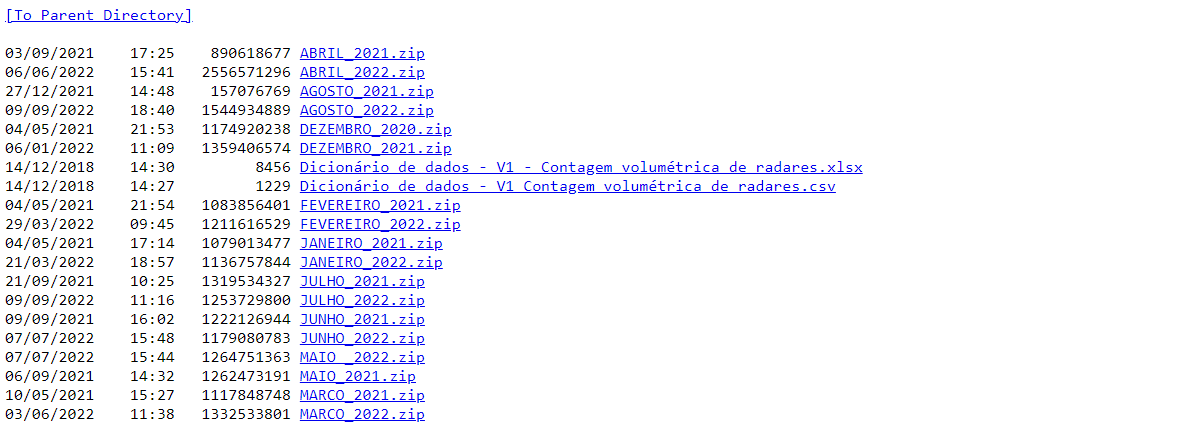
Após os dados serem lidos e transformados em um dataframe o mesmo é salvo em um arquivo .csv para posterior recuperação, já que esse processo leva uma quantidade de tempo considerável para uma apresentação.

In [479]:
mes_maio = '05'
dias_maio = ['01', '02', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']
mes_junho = '06'
dias_junho = ['01', '02', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']
horas_dia = ['00','01', '02', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']

In [6]:
df_final = pd.DataFrame(columns=['ID EQP', 'DATA HORA', 'MILESEGUNDO', 'FAIXA', 'ID DE ENDEREÇO', 'VELOCIDADE DA VIA', 'VELOCIDADE AFERIDA', 'CLASSIFICAÇÃO', 'TAMANHO', 'NUMERO DE SÉRIE', 'LATITUDE', 'LONGITUDE', 'ENDEREÇO', 'SENTIDO'])
for dia in dias_maio:
    for hora in horas_dia:
        caminho_arquivo = f'dados/fluxo_moto/2022{mes_maio}{dia}/2022{mes_maio}{dia}_{hora}.json'
        with open(caminho_arquivo, 'r', encoding="utf8") as f:
            str_json = f.read()
            dicionario_dados = json.loads(str_json)
            df_lido = pd.json_normalize(dicionario_dados)
            df_lido = df_lido.loc[df_lido['CLASSIFICAÇÃO'] == 'MOTO']
            df_lido['LATITUDE'] = df_lido['LATITUDE'].str.replace(' ', '').astype(float)
            df_lido['LONGITUDE'] = df_lido['LONGITUDE'].str.replace(' ', '').astype(float)
            df_lido = df_lido.loc[df_lido['LATITUDE'] == -19.9377]
            df_lido = df_lido.loc[df_lido['LONGITUDE'] == -43.92711]
            df_final = pd.concat([df_final, df_lido])
for dia in dias_junho:
    for hora in horas_dia:
        caminho_arquivo = f'dados/fluxo_moto/2022{mes_junho}{dia}/2022{mes_junho}{dia}_{hora}.json'
        with open(caminho_arquivo, 'r', encoding="utf8") as f:
            str_json = f.read()
            dicionario_dados = json.loads(str_json)
            df_lido = pd.json_normalize(dicionario_dados)
            df_lido = df_lido.loc[df_lido['CLASSIFICAÇÃO'] == 'MOTO']
            df_lido['LATITUDE'] = df_lido['LATITUDE'].str.replace(' ', '').astype(float)
            df_lido['LONGITUDE'] = df_lido['LONGITUDE'].str.replace(' ', '').astype(float)
            df_lido = df_lido.loc[df_lido['LATITUDE'] == -19.9377]
            df_lido = df_lido.loc[df_lido['LONGITUDE'] == -43.92711]
            df_final = pd.concat([df_final, df_lido])
df_final.rename(columns={'ID EQP': 'ID_EQP', 'DATA HORA': 'DATA_HORA', 'ID DE ENDEREÇO': 'ID_DE_ENDEREÇO', 'VELOCIDADE DA VIA':'VELOCIDADE_DA_VIA', 'VELOCIDADE AFERIDA':'VELOCIDADE_AFERIDA', 'CLASSIFICAÇÃO':'CLASSIFICACAO', 'NUMERO DE SÉRIE':'NUMERO_DE_SERIE', 'ENDEREÇO':'ENDERECO'}, inplace = True)
df_final.to_csv("dados/fluxo_moto/base_fluxo_motos.csv", index=False)

ID_EQP            DATA_HORA MILESEGUNDO FAIXA ID_DE_ENDEREÇO  \
1958     209  2022-05-01T00:02:34         647     2            335   
3328     209  2022-05-01T00:04:04         631     3            335   
3566     209  2022-05-01T00:04:20         100     3            335   
4480     209  2022-05-01T00:05:24         272     3            335   
5849     209  2022-05-01T00:06:53         991     2            335   
...      ...                  ...         ...   ...            ...   
26170    209  2022-06-30T23:42:29         626     3            335   
26187    209  2022-06-30T23:42:31         298     2            335   
26935    209  2022-06-30T23:43:56         751     2            335   
32800    209  2022-06-30T23:55:35         110     2            335   
32929    209  2022-06-30T23:55:52         641     2            335   

      VELOCIDADE_DA_VIA VELOCIDADE_AFERIDA CLASSIFICACAO TAMANHO  \
1958                 60              51.00          MOTO     1.0   
3328                 60              30.00          MOTO     1.0   
3566                 60              27.00          MOTO     1.0   
4480                 60              37.00          MOTO     1.0   
5849                 60              41.00          MOTO     1.0   
...                 ...                ...           ...     ...   
26170                60              48.00          MOTO     1.0   
26187                60              28.00          MOTO     1.0   
26935                60              49.00          MOTO     1.0   
32800                60              20.00          MOTO     1.0   
32929                60              48.00          MOTO     1.0   

      NUMERO_DE_SERIE  LATITUDE  LONGITUDE  \
1958             3283  -19.9377  -43.92711   
3328             3283  -19.9377  -43.92711   
3566             3283  -19.9377  -43.92711   
4480             3283  -19.9377  -43.92711   
5849             3283  -19.9377  -43.92711   
...               ...       ...        ...   
26170            3283  -19.9377  -43.92711   
26187            3283  -19.9377  -43.92711   
26935            3283  -19.9377  -43.92711   
32800            3283  -19.9377  -43.92711   
32929            3283  -19.9377  -43.92711   

                                        ENDERECO        SENTIDO  
1958   Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro  
3328   Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro  
3566   Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro  
4480   Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro  
5849   Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro  
...                                          ...            ...  
26170  Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro  
26187  Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro  
26935  Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro  
32800  Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro  
32929  Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro  

[55499 rows x 14 columns]

Nesta etapa, temos os dados que foram obtidos da base de dados e estruturados em um pandas dataframe. Temos muitas informações no registro das passagens dos veículos, dentre elas as que nos interessa é a de data e hora, localização e o tipo de veículo.

In [480]:
df_final.head(5)

ID_EQP            DATA_HORA MILESEGUNDO FAIXA ID_DE_ENDEREÇO  \
1958     209  2022-05-01T00:02:34         647     2            335   
3328     209  2022-05-01T00:04:04         631     3            335   
3566     209  2022-05-01T00:04:20         100     3            335   
4480     209  2022-05-01T00:05:24         272     3            335   
5849     209  2022-05-01T00:06:53         991     2            335   
...      ...                  ...         ...   ...            ...   
26170    209  2022-06-30T23:42:29         626     3            335   
26187    209  2022-06-30T23:42:31         298     2            335   
26935    209  2022-06-30T23:43:56         751     2            335   
32800    209  2022-06-30T23:55:35         110     2            335   
32929    209  2022-06-30T23:55:52         641     2            335   

      VELOCIDADE_DA_VIA VELOCIDADE_AFERIDA CLASSIFICACAO TAMANHO  \
1958                 60              51.00          MOTO     1.0   
3328                 60              30.00          MOTO     1.0   
3566                 60              27.00          MOTO     1.0   
4480                 60              37.00          MOTO     1.0   
5849                 60              41.00          MOTO     1.0   
...                 ...                ...           ...     ...   
26170                60              48.00          MOTO     1.0   
26187                60              28.00          MOTO     1.0   
26935                60              49.00          MOTO     1.0   
32800                60              20.00          MOTO     1.0   
32929                60              48.00          MOTO     1.0   

      NUMERO_DE_SERIE  LATITUDE  LONGITUDE  \
1958             3283  -19.9377  -43.92711   
3328             3283  -19.9377  -43.92711   
3566             3283  -19.9377  -43.92711   
4480             3283  -19.9377  -43.92711   
5849             3283  -19.9377  -43.92711   
...               ...       ...        ...   
26170            3283  -19.9377  -43.92711   
26187            3283  -19.9377  -43.92711   
26935            3283  -19.9377  -43.92711   
32800            3283  -19.9377  -43.92711   
32929            3283  -19.9377  -43.92711   

                                        ENDERECO        SENTIDO  
1958   Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro  
3328   Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro  
3566   Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro  
4480   Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro  
5849   Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro  
...                                          ...            ...  
26170  Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro  
26187  Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro  
26935  Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro  
32800  Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro  
32929  Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro  

[55499 rows x 14 columns]

## 2.2 - Geração da Tabela de Finais de Semana e Feriados

A base de dados contendo as informações de dias e horários foi sintetizada a partir dos pacotes date e datetime do python, onde foram avaliados todos os dias do período de observação se era um dia útil, um sábado, um domingo, ou um feriado. Para o caso de ser feriado, esses pacotes não puderam fornecer essa informação, então foi feito uma pesquisa na web para identificar os feriados nesse período, onde foi encontrado um único dia de feriado, o de Corpus Christi no dia 16 de junho de 2022.

A função abaixo tem como objetivo receber uma data e avaliar se é um dia de sábado, domingo, feriado de Corpus Christi ou um dia útil normal:

In [481]:
def avalia_tipo_dia(data_atual):
    tipo_dia = "DIA_UTIL"
    if data_atual.weekday() == 5:
        tipo_dia = 'SABADO'
    elif data_atual.weekday() == 6:
        tipo_dia = 'DOMINGO'
    elif format(data_atual, "%Y-%m-%d") == '2022-06-16':
        tipo_dia = 'FERIADO'
    return tipo_dia
    

O código abaixo gera um range de datas e horas que compreende do dia 01 de maio de 2022 às 0h até o dia 30 de junho de 2022 às 23h. Depois é criado um dataframe com a coluna DATA contendo esse range de datas e horas no formato datetime e por fim, são feitas iterações sobre essa coluna DATA do dataframe a fim de gerar as colunas DATA_HORA_COMPARADOR e TIPO_DIA. A coluna DATA_HORA_COMPARADOR serve como uma referência para ser utilizada futuramente na junção das bases de dados. Por último a coluna TIPO_DIA contém as informações dos tipos de dia.

In [484]:
datas = pd.date_range(start ='2022-05-01 00:00:00', end ='2022-06-30 23:00:00', periods = 1464)   
base_datas = pd.DataFrame(datas, columns=['DATA'])
base_datas['DATA_HORA_COMPARADOR'] = base_datas['DATA'].apply(lambda data_atual: format(data_atual, "%Y-%m-%dT%H:00:00"))
base_datas['DATA_COMPARADOR'] = base_datas['DATA'].apply(lambda data_atual: format(data_atual, "%Y-%m-%d"))
base_datas['TIPO_DIA'] = base_datas['DATA'].apply(lambda data_atual: avalia_tipo_dia(data_atual))

Depois que essa segunda base foi gerada, a mesma foi salva para posterior leitura.

In [485]:
base_datas.to_csv("dados/fluxo_moto/base_datas.csv", index=False)
base_datas

DATA DATA_HORA_COMPARADOR DATA_COMPARADOR  TIPO_DIA
0    2022-05-01 00:00:00  2022-05-01T00:00:00      2022-05-01   DOMINGO
1    2022-05-01 01:00:00  2022-05-01T01:00:00      2022-05-01   DOMINGO
2    2022-05-01 02:00:00  2022-05-01T02:00:00      2022-05-01   DOMINGO
3    2022-05-01 03:00:00  2022-05-01T03:00:00      2022-05-01   DOMINGO
4    2022-05-01 04:00:00  2022-05-01T04:00:00      2022-05-01   DOMINGO
...                  ...                  ...             ...       ...
1459 2022-06-30 19:00:00  2022-06-30T19:00:00      2022-06-30  DIA_UTIL
1460 2022-06-30 20:00:00  2022-06-30T20:00:00      2022-06-30  DIA_UTIL
1461 2022-06-30 21:00:00  2022-06-30T21:00:00      2022-06-30  DIA_UTIL
1462 2022-06-30 22:00:00  2022-06-30T22:00:00      2022-06-30  DIA_UTIL
1463 2022-06-30 23:00:00  2022-06-30T23:00:00      2022-06-30  DIA_UTIL

[1464 rows x 4 columns]

## 2.3 - Geração da Tabela com Dados Climáticos

A base dos dados climáticos foi construída a partir de uma API pública e gratuita, que pode ser acessada pelo endereço: https://archive-api.open-meteo.com. O processo para a construção desta base é semelhante à anterior, primeiro são gradas as colunas DATA e DATA_HORA_COMPARADOR e posteriormente as colunas TEMPERATURA e PRECIPITACAO que são preenchidas utilizando a função retorna_dados_metereologicos. Essa função, retorna_dados_metereologicos, recebe os dados de latitude e longitude (fixos, pois foi estudado apenas um ponto na cidade de Belo Horizonte) e também a data e hora, retornando um dicionário com a temperatura e precipitação. Ao terminar de construir essa base dados, a mesma é salva em um arquivo .csv para posterior leitura.

In [8]:
datas = pd.date_range(start ='2022-05-01 00:00:00', end ='2022-06-30 23:00:00', periods = 1464)
base_clima = pd.DataFrame(datas, columns=['DATA'])
base_clima['DATA_HORA_COMPARADOR'] = base_clima['DATA'].apply(lambda data_atual: format(data_atual, "%Y-%m-%dT%H:00:00"))
base_clima

DATA DATA_HORA_COMPARADOR
0    2022-05-01 00:00:00  2022-05-01T00:00:00
1    2022-05-01 01:00:00  2022-05-01T01:00:00
2    2022-05-01 02:00:00  2022-05-01T02:00:00
3    2022-05-01 03:00:00  2022-05-01T03:00:00
4    2022-05-01 04:00:00  2022-05-01T04:00:00
...                  ...                  ...
1459 2022-06-30 19:00:00  2022-06-30T19:00:00
1460 2022-06-30 20:00:00  2022-06-30T20:00:00
1461 2022-06-30 21:00:00  2022-06-30T21:00:00
1462 2022-06-30 22:00:00  2022-06-30T22:00:00
1463 2022-06-30 23:00:00  2022-06-30T23:00:00

[1464 rows x 2 columns]

Função para buscar os dados climáticos na API:

In [9]:
def retorna_dados_metereologicos(data_hora, latitude, longitude):
    dataDate = datetime.strptime(data_hora, '%Y-%m-%dT%H:%M:%S')
    dataStrRequest = dataDate.strftime('%Y-%m-%d')
    
    #chamada
    url = "https://archive-api.open-meteo.com/v1/era5?latitude="+str(latitude)+"&longitude="+str(longitude)+"&start_date="+str(dataStrRequest)+"&end_date="+str(dataStrRequest)+"&hourly=temperature_2m,precipitation"
    response = requests.get(url)
    jsonObj = response.json()
    
    #pegando atributos
    dataStrComparador = dataDate.strftime('%Y-%m-%dT%H:00')
    indiceDataHora = jsonObj['hourly']['time'].index(dataStrComparador)
    
    temperature_2m = jsonObj['hourly']['temperature_2m'][indiceDataHora]
    precipitation = jsonObj['hourly']['precipitation'][indiceDataHora]
    
    return dict({'temperature_2m': temperature_2m, 'precipitation': precipitation})

In [10]:
teste = retorna_dados_metereologicos("2022-05-01T00:00:00", -19.9377, -43.92711)
teste

{'temperature_2m': 15.8, 'precipitation': 0.0}

Percorrendo o dataframe grado com as datas e horários e agregando os dados de temperatura e precipitação

In [11]:
base_clima['TEMPERATURA'] = np.nan
base_clima['PRECIPITACAO'] = np.nan
for i in base_clima.index:
    dados_clima = retorna_dados_metereologicos(base_clima['DATA_HORA_COMPARADOR'][i], -19.9377, -43.92711)
    base_clima.loc[i,'TEMPERATURA'] = dados_clima['temperature_2m']
    base_clima.loc[i,'PRECIPITACAO'] = dados_clima['precipitation']
base_clima.to_csv("dados/fluxo_moto/base_clima.csv", index=False)


DATA DATA_HORA_COMPARADOR  TEMPERATURA  PRECIPITACAO
0    2022-05-01 00:00:00  2022-05-01T00:00:00         15.8           0.0
1    2022-05-01 01:00:00  2022-05-01T01:00:00         15.1           0.0
2    2022-05-01 02:00:00  2022-05-01T02:00:00         14.7           0.0
3    2022-05-01 03:00:00  2022-05-01T03:00:00         14.4           0.0
4    2022-05-01 04:00:00  2022-05-01T04:00:00         14.4           0.0
...                  ...                  ...          ...           ...
1459 2022-06-30 19:00:00  2022-06-30T19:00:00         23.2           0.0
1460 2022-06-30 20:00:00  2022-06-30T20:00:00         21.8           0.0
1461 2022-06-30 21:00:00  2022-06-30T21:00:00         17.3           0.0
1462 2022-06-30 22:00:00  2022-06-30T22:00:00         14.3           0.0
1463 2022-06-30 23:00:00  2022-06-30T23:00:00         13.5           0.0

[1464 rows x 4 columns]

Base com os dados climáticos finalizada

In [486]:
base_clima

DATA DATA_HORA_COMPARADOR  TEMPERATURA  PRECIPITACAO
0    2022-05-01 00:00:00  2022-05-01T00:00:00         15.8           0.0
1    2022-05-01 01:00:00  2022-05-01T01:00:00         15.1           0.0
2    2022-05-01 02:00:00  2022-05-01T02:00:00         14.7           0.0
3    2022-05-01 03:00:00  2022-05-01T03:00:00         14.4           0.0
4    2022-05-01 04:00:00  2022-05-01T04:00:00         14.4           0.0
...                  ...                  ...          ...           ...
1459 2022-06-30 19:00:00  2022-06-30T19:00:00         23.2           0.0
1460 2022-06-30 20:00:00  2022-06-30T20:00:00         21.8           0.0
1461 2022-06-30 21:00:00  2022-06-30T21:00:00         17.3           0.0
1462 2022-06-30 22:00:00  2022-06-30T22:00:00         14.3           0.0
1463 2022-06-30 23:00:00  2022-06-30T23:00:00         13.5           0.0

[1464 rows x 4 columns]

# 3 - Processamento/Tratamento de Dados

Após ter as três bases carregadas e padronizadas em um pandas dataframe, nesta etapa foi feito o processamento dos dados do registro da contagem volumétrica de radares de Belo Horizonte no ponto estudado e o enriquecimento da base resultante com dados climáticos e de do tipo de dia. No desenho abaixo é possível ver esse fluxo de processamento da base:
No desenho abaixo é possível ver o fluxo de processamento das bases até gerar a base final:
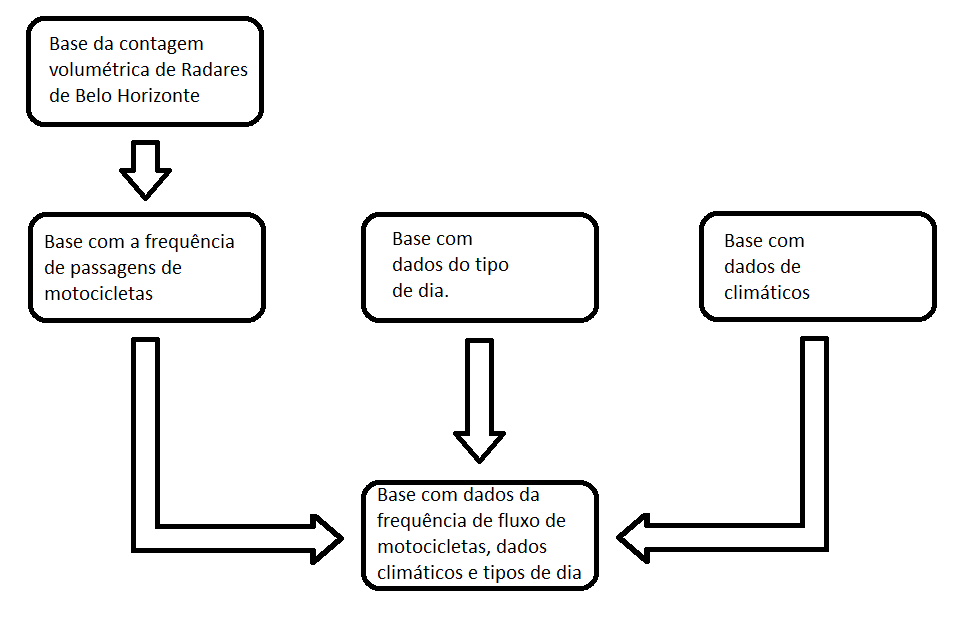

## 3.1 - Gerando Base de Frequência de Fluxo de Motocicletas por Hora

A base de frequência de cruzamento de motocicletas foi gerada a partir dos registros da contagem volumétricas dos radares, claro, olhando sempre para o mesmo radar da Av. Afonso Pena. 
A contagem foi feita por hora, ou seja, contabilizou-se a quantidade de motocicletas que cruzaram o radar da Av. Afonso Pena por hora e foi registrado esse dado na coluna ‘FREQUENCIA’.
A estratégia para tal feito foi zerar as informações de minutos e segundos, deixando apenas as informações de hora e isso foi feito utilizando a função “data_hora_minuto”. Depois utilizou-se da função “value_counts” para contar quantos registro repetidos de data e hora existem, chegando em um tabela de frequência. Por fim, gerou-se um dataframe com todos os registros de datas e horas compreendidos dentro do período observado e agregou-se as informações de frequência.


In [110]:
base_fluxo_motocicleta = pd.read_csv('dados/fluxo_moto/base_fluxo_motos.csv')

In [111]:
base_fluxo_motocicleta.head(3)

ID_EQP            DATA_HORA  MILESEGUNDO  FAIXA  ID_DE_ENDEREÇO  \
0     209  2022-05-01T00:02:34          647      2             335   
1     209  2022-05-01T00:04:04          631      3             335   
2     209  2022-05-01T00:04:20          100      3             335   

   VELOCIDADE_DA_VIA  VELOCIDADE_AFERIDA CLASSIFICACAO  TAMANHO  \
0                 60                51.0          MOTO      1.0   
1                 60                30.0          MOTO      1.0   
2                 60                27.0          MOTO      1.0   

   NUMERO_DE_SERIE  LATITUDE  LONGITUDE  \
0             3283  -19.9377  -43.92711   
1             3283  -19.9377  -43.92711   
2             3283  -19.9377  -43.92711   

                                    ENDERECO        SENTIDO  
0  Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro  
1  Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro  
2  Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro

In [112]:
base_fluxo_motocicleta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55499 entries, 0 to 55498
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_EQP              55499 non-null  int64  
 1   DATA_HORA           55499 non-null  object 
 2   MILESEGUNDO         55499 non-null  int64  
 3   FAIXA               55499 non-null  int64  
 4   ID_DE_ENDEREÇO      55499 non-null  int64  
 5   VELOCIDADE_DA_VIA   55499 non-null  int64  
 6   VELOCIDADE_AFERIDA  55499 non-null  float64
 7   CLASSIFICACAO       55499 non-null  object 
 8   TAMANHO             55499 non-null  float64
 9   NUMERO_DE_SERIE     55499 non-null  int64  
 10  LATITUDE            55499 non-null  float64
 11  LONGITUDE           55499 non-null  float64
 12  ENDERECO            55499 non-null  object 
 13  SENTIDO             55499 non-null  object 
dtypes: float64(4), int64(6), object(4)
memory usage: 5.9+ MB


In [113]:
def data_hora_minuto(data_hora):
    dataDate = datetime.strptime(data_hora, '%Y-%m-%dT%H:%M:%S')
    dataStrRetorno = dataDate.strftime('%Y-%m-%dT%H:00:00')
    return dataStrRetorno

In [114]:
base_fluxo_motocicleta['HORA_PASSAGEM_MOTO'] = base_fluxo_motocicleta['DATA_HORA'].apply(lambda data_hora_atual: data_hora_minuto(data_hora_atual))

In [115]:
base_fluxo_motocicleta.head(3)

ID_EQP            DATA_HORA  MILESEGUNDO  FAIXA  ID_DE_ENDEREÇO  \
0     209  2022-05-01T00:02:34          647      2             335   
1     209  2022-05-01T00:04:04          631      3             335   
2     209  2022-05-01T00:04:20          100      3             335   

   VELOCIDADE_DA_VIA  VELOCIDADE_AFERIDA CLASSIFICACAO  TAMANHO  \
0                 60                51.0          MOTO      1.0   
1                 60                30.0          MOTO      1.0   
2                 60                27.0          MOTO      1.0   

   NUMERO_DE_SERIE  LATITUDE  LONGITUDE  \
0             3283  -19.9377  -43.92711   
1             3283  -19.9377  -43.92711   
2             3283  -19.9377  -43.92711   

                                    ENDERECO        SENTIDO  \
0  Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro   
1  Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro   
2  Av. Afonso Pena, esquina com Rua Maranhão  Bairro/Centro   

    HORA_PASSAGEM_MOTO  
0  2022-05-01T00:00:00  
1  2022-05-01T00:00:00  
2  2022-05-01T00:00:00

In [116]:
frequencia_fluxo_motos_data = base_fluxo_motocicleta['HORA_PASSAGEM_MOTO'].value_counts()
frequencia_fluxo_motos_data

2022-06-07T17:00:00    120
2022-06-06T17:00:00    116
2022-06-20T18:00:00    115
2022-06-10T17:00:00    115
2022-05-12T18:00:00    113
                      ... 
2022-06-27T04:00:00      2
2022-06-21T02:00:00      2
2022-05-19T02:00:00      1
2022-05-11T04:00:00      1
2022-06-02T04:00:00      1
Name: HORA_PASSAGEM_MOTO, Length: 1353, dtype: int64

In [117]:
frequencia_fluxo_motos_data['2022-05-01T02:00:00']

21

In [118]:
def recupera_frequencia(indice, frequencia_fluxo_motos_data):
    freq = 0
    try:
        freq = frequencia_fluxo_motos_data[indice]
    except:
        freq = 0
    return freq

In [119]:
datas = pd.date_range(start ='2022-05-01 00:00:00', end ='2022-06-30 23:00:00', periods = 1464)
base_frequencia_fluxo_moto = pd.DataFrame(datas, columns=['DATA'])
base_frequencia_fluxo_moto['DATA_HORA_COMPARADOR'] = base_frequencia_fluxo_moto['DATA'].apply(lambda data_atual: format(data_atual, "%Y-%m-%dT%H:00:00"))
base_frequencia_fluxo_moto['HORA'] = base_frequencia_fluxo_moto['DATA'].apply(lambda data_atual: format(data_atual, "%H"))

base_frequencia_fluxo_moto['FREQUENCIA'] = np.nan

for i in base_frequencia_fluxo_moto.index:
    try:
        base_frequencia_fluxo_moto.loc[i,'FREQUENCIA'] = frequencia_fluxo_motos_data[base_frequencia_fluxo_moto['DATA_HORA_COMPARADOR'][i]]
    except:
        base_frequencia_fluxo_moto.loc[i,'FREQUENCIA'] = 0

base_frequencia_fluxo_moto

DATA DATA_HORA_COMPARADOR HORA  FREQUENCIA
0    2022-05-01 00:00:00  2022-05-01T00:00:00   00        37.0
1    2022-05-01 01:00:00  2022-05-01T01:00:00   01        30.0
2    2022-05-01 02:00:00  2022-05-01T02:00:00   02        21.0
3    2022-05-01 03:00:00  2022-05-01T03:00:00   03         0.0
4    2022-05-01 04:00:00  2022-05-01T04:00:00   04        10.0
...                  ...                  ...  ...         ...
1459 2022-06-30 19:00:00  2022-06-30T19:00:00   19        60.0
1460 2022-06-30 20:00:00  2022-06-30T20:00:00   20        47.0
1461 2022-06-30 21:00:00  2022-06-30T21:00:00   21        37.0
1462 2022-06-30 22:00:00  2022-06-30T22:00:00   22        40.0
1463 2022-06-30 23:00:00  2022-06-30T23:00:00   23        21.0

[1464 rows x 4 columns]

### 3.1.1 - Limpando e Transformando a Base de Frequênca de Fluxo de Motocicletas

Foi gerado um diagrama de caixa (boxplot) da coluna FREQUENCIA a fim de encontrar algum outrlier, porém não foram encontrados outliers.

<AxesSubplot:xlabel='FREQUENCIA'>

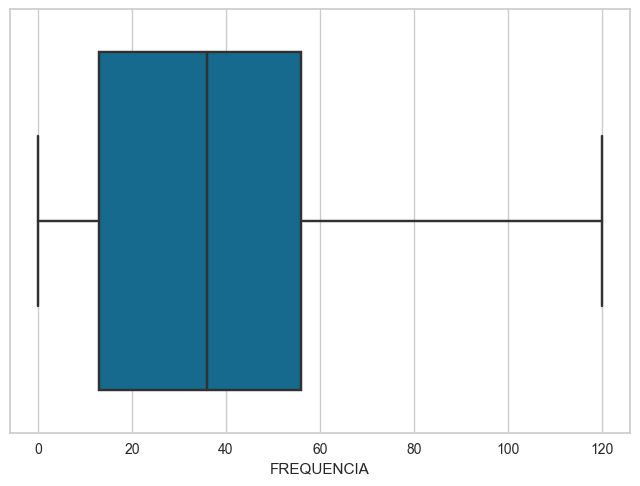

In [120]:
sns.boxplot(x=base_frequencia_fluxo_moto['FREQUENCIA'])

Apesar de não existir outliers na coluna FREQUENCIA, percebeu-se através de análise gráfica que existe uma quantidade discrepante de registros zerados, ou seja, de horários em que não foram registradas passagens de motocicletas pelo radar analisado. O que podemos ver no gráfico abaixo:

<AxesSubplot:xlabel='FREQUENCIA', ylabel='count'>

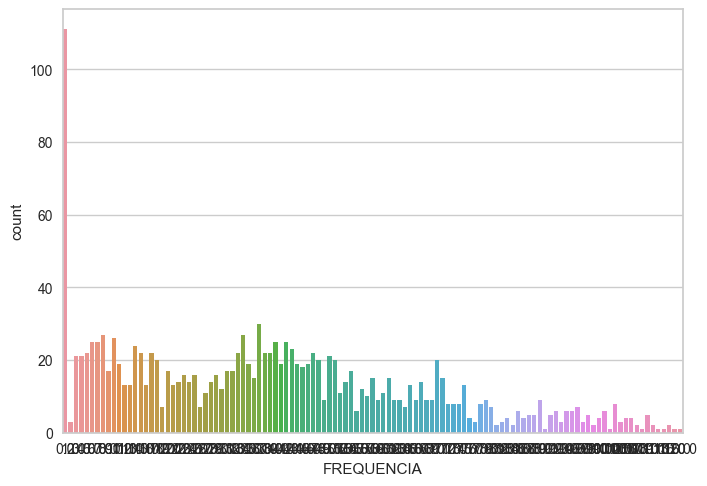

In [121]:
sns.countplot(x = base_frequencia_fluxo_moto['FREQUENCIA'])

In [122]:
base_frequencia_fluxo_moto['FREQUENCIA'].describe()

count    1464.000000
mean       37.909153
std        28.060682
min         0.000000
25%        13.000000
50%        36.000000
75%        56.000000
max       120.000000
Name: FREQUENCIA, dtype: float64

Com a finalidade de melhor visualizar o gráfico anterior, foi feito um zoom nos registros de menores frequências:

<AxesSubplot:xlabel='FREQUENCIA', ylabel='count'>

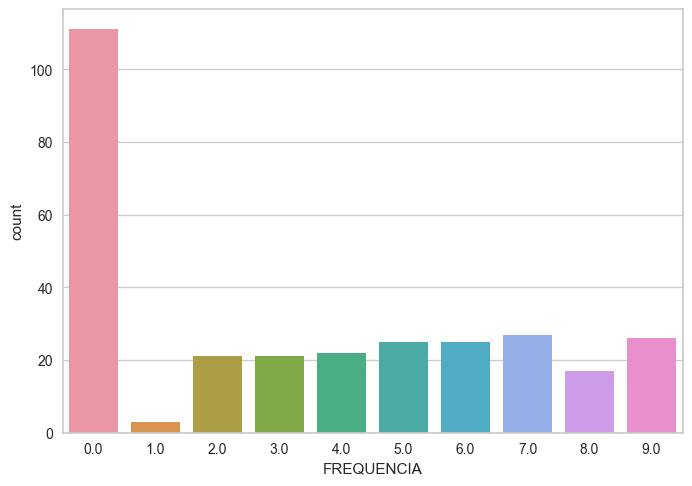

In [123]:
base_freq_janela = base_frequencia_fluxo_moto.loc[base_frequencia_fluxo_moto.FREQUENCIA < 10]
sns.countplot(x = base_freq_janela['FREQUENCIA'])

Com o objetivo de investigar as ocorrências de registros de frequência com zero, gerou-se o dataframe base_analise_freq_zero apenas com os registros zerados e percebeu-se que a maioria dos registros zerados ocorreram às 3 horas da madrugada.

In [124]:
base_analise_freq_zero = base_frequencia_fluxo_moto.loc[base_frequencia_fluxo_moto.FREQUENCIA == 0.0]
base_analise_freq_zero

DATA DATA_HORA_COMPARADOR HORA  FREQUENCIA
3    2022-05-01 03:00:00  2022-05-01T03:00:00   03         0.0
27   2022-05-02 03:00:00  2022-05-02T03:00:00   03         0.0
48   2022-05-03 00:00:00  2022-05-03T00:00:00   00         0.0
49   2022-05-03 01:00:00  2022-05-03T01:00:00   01         0.0
50   2022-05-03 02:00:00  2022-05-03T02:00:00   02         0.0
...                  ...                  ...  ...         ...
1347 2022-06-26 03:00:00  2022-06-26T03:00:00   03         0.0
1371 2022-06-27 03:00:00  2022-06-27T03:00:00   03         0.0
1395 2022-06-28 03:00:00  2022-06-28T03:00:00   03         0.0
1419 2022-06-29 03:00:00  2022-06-29T03:00:00   03         0.0
1443 2022-06-30 03:00:00  2022-06-30T03:00:00   03         0.0

[111 rows x 4 columns]

Analisando a coluna HORA do dataframe base_analise_freq_zero, pode-se perceber que a maior ocorrência é de fato às 3h da madrugada, ocorrendo poucas vezes em outros horários. Não foi possível encontrar informações sobre o motivo dessa anomalia, o que pode-se supor que os horários em que existem registros zerados possivelmente são horários de manutenção dos equipamentos ou de descarga de dados, sendo compreensível essa informação não ser divulgada oficialmente.


<AxesSubplot:xlabel='HORA', ylabel='count'>

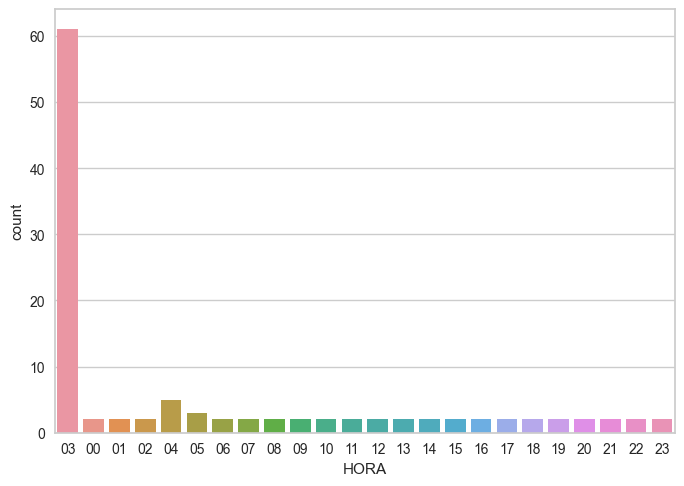

In [125]:
sns.countplot(x = base_analise_freq_zero['HORA'])

Como os horários que possuem frequências zeradas não possuem informações de fato sobre o fluxo de motocicletas e também não sendo possível buscar essa informação em outras fontes, optou-se por excluir os registros de frequências zeradas.

In [126]:
base_frequencia_fluxo_moto = base_frequencia_fluxo_moto.drop(base_frequencia_fluxo_moto[base_frequencia_fluxo_moto['FREQUENCIA']==0.0].index)

<AxesSubplot:xlabel='FREQUENCIA', ylabel='count'>

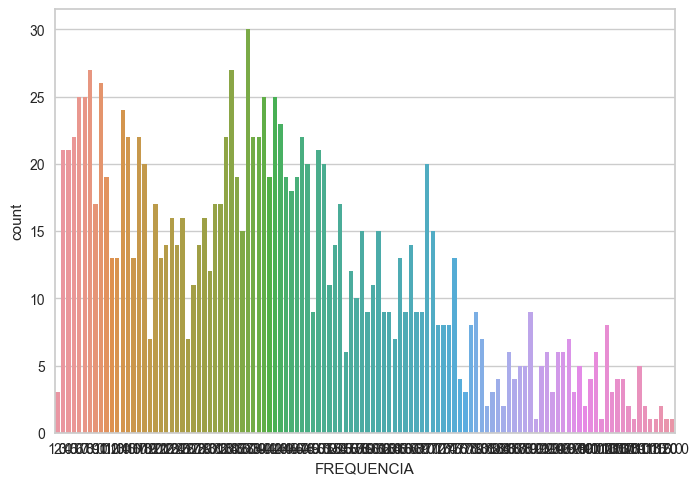

In [127]:
sns.countplot(x = base_frequencia_fluxo_moto['FREQUENCIA'])

In [128]:
base_frequencia_fluxo_moto['FREQUENCIA'].describe()

count    1353.000000
mean       41.019217
std        26.914332
min         1.000000
25%        18.000000
50%        38.000000
75%        58.000000
max       120.000000
Name: FREQUENCIA, dtype: float64

Depois de tratar e limpar os registros zerados de frequência, a média das frequências registradas foi calculada e foi gerada outra coluna no dataframe base_frequencia_fluxo_moto chamada ACIMA_MEDIA_FREQUENCIA, que classifica se na determinada data e horário houve uma frequência de fluxo acima ou abaixo da média, onde 0 o registro está abaixo da média e 1 está acima da média da frequência de cruzamento de motocicletas pelo ponto observado.

In [129]:
media_freq = base_frequencia_fluxo_moto['FREQUENCIA'].mean()
media_freq

41.01921655580192

In [130]:
base_frequencia_fluxo_moto['ACIMA_MEDIA_FREQUENCIA'] = base_frequencia_fluxo_moto['FREQUENCIA'].apply(lambda freq_atual : 1 if freq_atual > media_freq else 0)

In [131]:
base_frequencia_fluxo_moto.head(5)

DATA DATA_HORA_COMPARADOR HORA  FREQUENCIA  \
0 2022-05-01 00:00:00  2022-05-01T00:00:00   00        37.0   
1 2022-05-01 01:00:00  2022-05-01T01:00:00   01        30.0   
2 2022-05-01 02:00:00  2022-05-01T02:00:00   02        21.0   
4 2022-05-01 04:00:00  2022-05-01T04:00:00   04        10.0   
5 2022-05-01 05:00:00  2022-05-01T05:00:00   05         5.0   

   ACIMA_MEDIA_FREQUENCIA  
0                       0  
1                       0  
2                       0  
4                       0  
5                       0

## 3.2 - Mesclando as Bases de Frequência de Fluxo, de Clima e de Dias

Para facilitar a junção das três base de dados, como todas elas estão orientadas a data e horário, criou-se uma coluna chamada DATA_HORA_COMPARADOR cujo o registro de data hora tem um formato idêntico das três bases, assim facilitando gerar a base final com todos os dados.

In [132]:
base = ""
base_datas = pd.read_csv("dados/fluxo_moto/base_datas.csv")
base_datas.head(3)

DATA DATA_HORA_COMPARADOR DATA_COMPARADOR TIPO_DIA
0  2022-05-01 00:00:00  2022-05-01T00:00:00      2022-05-01  DOMINGO
1  2022-05-01 01:00:00  2022-05-01T01:00:00      2022-05-01  DOMINGO
2  2022-05-01 02:00:00  2022-05-01T02:00:00      2022-05-01  DOMINGO

In [133]:
base_clima = pd.read_csv("dados/fluxo_moto/base_clima.csv")
base_clima.head(3)

DATA DATA_HORA_COMPARADOR  TEMPERATURA  PRECIPITACAO
0  2022-05-01 00:00:00  2022-05-01T00:00:00         15.8           0.0
1  2022-05-01 01:00:00  2022-05-01T01:00:00         15.1           0.0
2  2022-05-01 02:00:00  2022-05-01T02:00:00         14.7           0.0

In [134]:
base = base_frequencia_fluxo_moto

In [135]:
base.insert(loc = 3, column = 'TEMPERATURA', value = base['DATA_HORA_COMPARADOR'].map(lambda x : base_clima.loc[base_clima.DATA_HORA_COMPARADOR == x].iloc[0]['TEMPERATURA']))

In [136]:
base.insert(loc = 3, column = 'PRECIPITACAO', value = base['DATA_HORA_COMPARADOR'].map(lambda x : base_clima.loc[base_clima.DATA_HORA_COMPARADOR == x].iloc[0]['PRECIPITACAO']))

In [137]:
base.insert(loc = 3, column = 'TIPO_DIA', value = base['DATA_HORA_COMPARADOR'].map(lambda x : base_datas.loc[base_datas.DATA_HORA_COMPARADOR == x].iloc[0]['TIPO_DIA']))

In [138]:
base = base.drop(['DATA_HORA_COMPARADOR', 'DATA', 'FREQUENCIA'], axis=1)

In [139]:
base.columns[base.isna().any()].tolist()

[]

In [140]:
base.describe()

PRECIPITACAO  TEMPERATURA  ACIMA_MEDIA_FREQUENCIA
count   1353.000000  1353.000000             1353.000000
mean       0.015669    15.413156                0.445676
std        0.105218     4.667042                0.497224
min        0.000000     3.600000                0.000000
25%        0.000000    11.900000                0.000000
50%        0.000000    15.200000                0.000000
75%        0.000000    19.000000                1.000000
max        1.400000    25.700000                1.000000

In [141]:
base.head(10)

HORA TIPO_DIA  PRECIPITACAO  TEMPERATURA  ACIMA_MEDIA_FREQUENCIA
0    00  DOMINGO           0.0         15.8                       0
1    01  DOMINGO           0.0         15.1                       0
2    02  DOMINGO           0.0         14.7                       0
4    04  DOMINGO           0.0         14.4                       0
5    05  DOMINGO           0.0         14.0                       0
6    06  DOMINGO           0.0         13.7                       0
7    07  DOMINGO           0.0         12.9                       0
8    08  DOMINGO           0.0         13.0                       0
9    09  DOMINGO           0.0         12.7                       0
10   10  DOMINGO           0.0         14.9                       0

Depois que as três bases foram unidas, a base resultante foi salva em um arquivo .CSV para posterior recuperação:

In [142]:
base.to_csv("dados/fluxo_moto/base_fluxo_motos_tratada.csv", index=False)

# 4 - Análise e Exploração dos Dados

Nesta etapa analisou-se cada coluna da base de dados objetivando encontrar anomalias como outliers e campos nulos. Já adianta-se que não foram encontrados dados faltantes ou outliers, pois pela característica da transformação e construção das bases de origem a base final encontra-se sem dados nulos ou inconsistentes.

Para facilitar a construção de alguns gráficos, foram criadas as funções plota_countplot e plota_histplot:

In [5]:
def plota_countplot(base_principal, variavel, titulo_x, titulo_y, titulo_do_grafico):
    plt.clf()
    grafico = sns.countplot(x=base_principal[variavel])
    grafico.set_ylabel('Quantidade de Ocorrências'); 
    grafico.set_title(f'{titulo_do_grafico}\n'); 
    plt.show()

In [6]:
def plota_histplot(base_principal, variavel, titulo_x, titulo_y, titulo_do_grafico):
    plt.clf()
    grafico = sns.histplot(x=base_principal[variavel])
    grafico.set_ylabel('Quantidade de Ocorrências'); 
    grafico.set_title(f'{titulo_do_grafico}\n'); 
    plt.show()

Recuperando a base de fluxo de motos final para análise

In [7]:
base = pd.read_csv("dados/fluxo_moto/base_fluxo_motos_tratada.csv")
base

HORA  TIPO_DIA  PRECIPITACAO  TEMPERATURA  ACIMA_MEDIA_FREQUENCIA
0        0   DOMINGO           0.0         15.8                       0
1        1   DOMINGO           0.0         15.1                       0
2        2   DOMINGO           0.0         14.7                       0
3        4   DOMINGO           0.0         14.4                       0
4        5   DOMINGO           0.0         14.0                       0
...    ...       ...           ...          ...                     ...
1348    19  DIA_UTIL           0.0         23.2                       1
1349    20  DIA_UTIL           0.0         21.8                       1
1350    21  DIA_UTIL           0.0         17.3                       0
1351    22  DIA_UTIL           0.0         14.3                       0
1352    23  DIA_UTIL           0.0         13.5                       0

[1353 rows x 5 columns]

Verificando se existem dados nulos ou inconsistentes

In [8]:
base.isna().sum()

HORA                      0
TIPO_DIA                  0
PRECIPITACAO              0
TEMPERATURA               0
ACIMA_MEDIA_FREQUENCIA    0
dtype: int64

In [9]:
base.isnull().sum()

HORA                      0
TIPO_DIA                  0
PRECIPITACAO              0
TEMPERATURA               0
ACIMA_MEDIA_FREQUENCIA    0
dtype: int64

### 4.1 - Visualização e Análise dos Dados por Coluna

### 4.1.1 Variável  ACIMA_MEDIA_FREQUENCIA

A variável categórica nominal ACIMA_MEDIA_FREQUENCIA representa se houve um fluxo maior ou menor que a média de motocicletas no ponto estudado.
Como o objetivo deste trabalho é analisar o que influencia no fluxo de motocicletas em um determinado ponto da cidade de Belo Horizonte, a primeira variável analisada foi a ACIMA_MEDIA_FREQUENCIA que classificação do fluxo de motocicletas quanto a média e em um determinado horário. Esta variável que será a variável alvo do modelo, está levemente desbalanceada, contando com 750 registros abaixo da média e 603 acima da média de passagens de motocicletas.


In [10]:
np.unique(base['ACIMA_MEDIA_FREQUENCIA'], return_counts = True) 

(array([0, 1], dtype=int64), array([750, 603], dtype=int64))

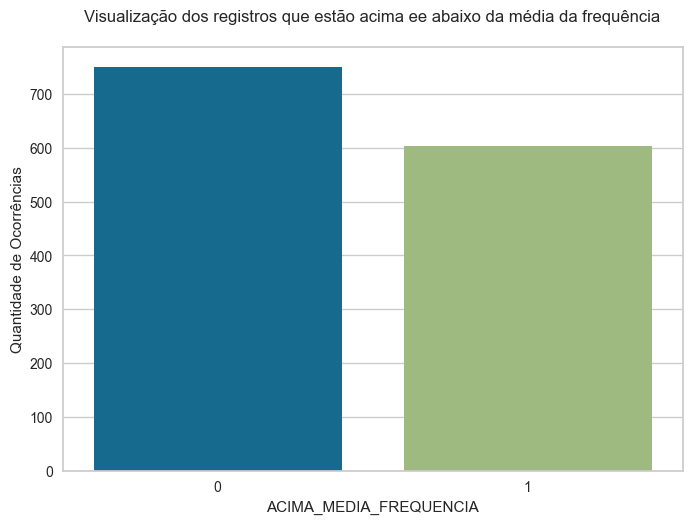

In [11]:
plota_countplot(base, 'ACIMA_MEDIA_FREQUENCIA', 'Acima da média da frequência', 'Quantidade de Ocorrências', 'Visualização dos registros que estão acima ee abaixo da média da frequência')

### 4.1.2 - Variável HORA

A variável numérica ordinal HORA, que é exatamente o valor inteiro da hora a qual se refere o registro de fluxo de motocicletas, foi mostrada em um gráfico do tipo countplot e percebeu-se que não existem registros para às 3h da madrugada, o que já tinha sido percebido durante a construção e limpeza da base de fluxo de motocicletas, ficando nítido também no gráfico abaixo.

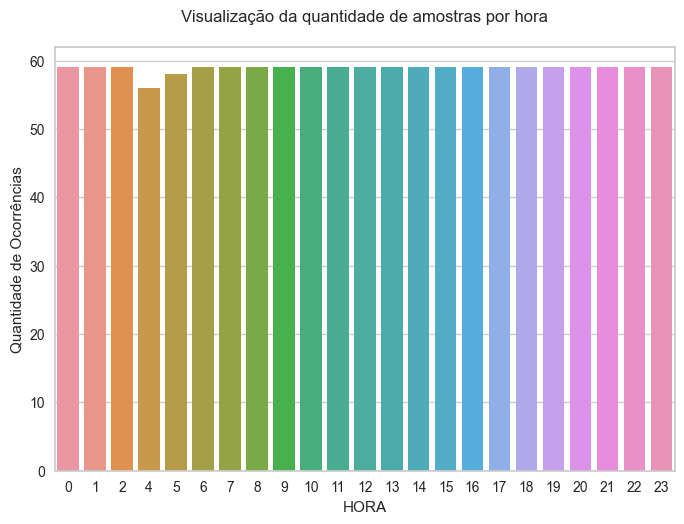

In [12]:
#sns.countplot(x = base['HORA'])
plota_countplot(base, 'HORA', 'Hora', 'Quantidade de Ocorrências', 'Visualização da quantidade de amostras por hora')

Para a análise da variável TEMPERATURA

### 4.1.3 - Variável TEMPERATURA

A variável numérica contínua TEMPERATURA representa a temperatura na hora em que foi feita a medição da frequência de cruzamentos de motocicletas pelo ponto estudado. Para a análise da variável temperatura, construiu-se tanto um histograma quanto um diagrama de caixas (boxplot), percebeu-se que não existem outliers e temos uma temperatura média em torno de 15 graus (Levando em consideração o dia e a noite).

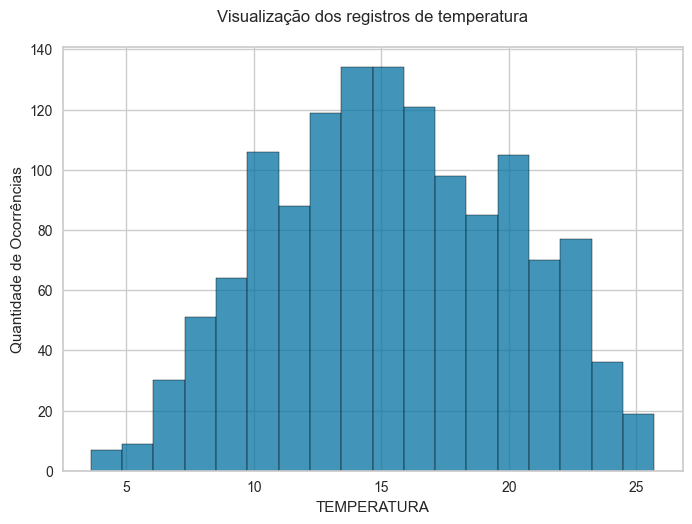

In [13]:
#sns.histplot(x = base['TEMPERATURA'])
plota_histplot(base, 'TEMPERATURA', 'Temperatura durante a hora de registros', 'Quantidade de Ocorrências', 'Visualização dos registros de temperatura')

<AxesSubplot:xlabel='TEMPERATURA'>

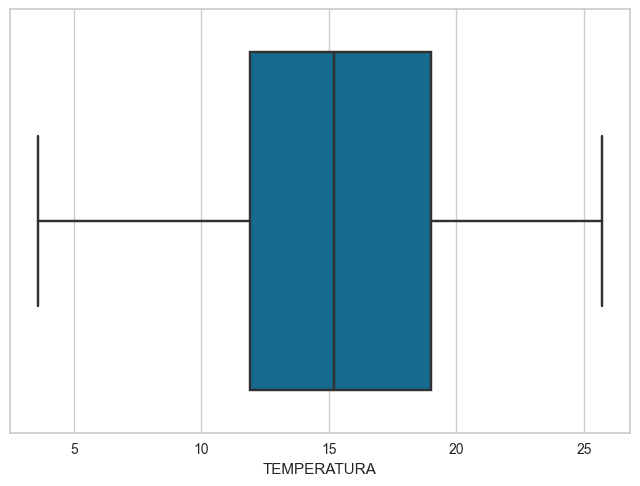

In [14]:
sns.boxplot(x=base['TEMPERATURA'])

### 4.1.4 - Variável TIPO_DIA

A variável categórica nominal TIPO_DIA classifica o dia da observação em dia útil, sábado, domingo ou feriado. De acordo com o gráfico de contagem de registros mostrado abaixo, pode-se perceber que a grande maioria dos registros foram durante dias úteis, o que já se espera pois foram observados todos os dias durantes os meses de maio e junho de 2022.

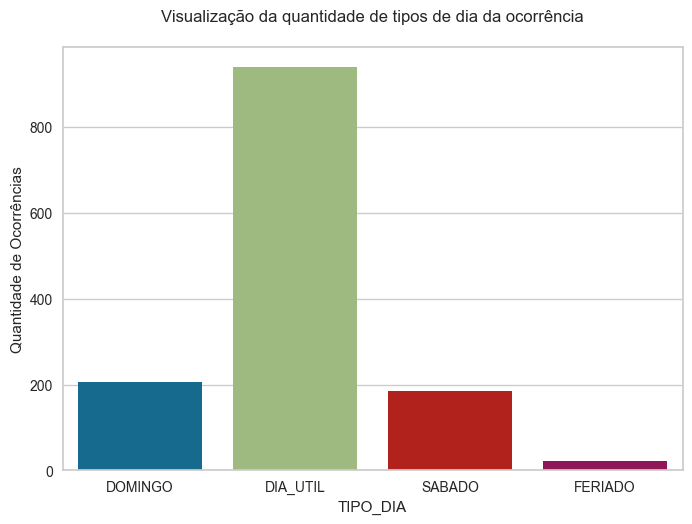

In [15]:
#sns.countplot(x = base['TIPO_DIA'])
plota_countplot(base, 'TIPO_DIA', 'Tipo do dia do registro', 'Quantidade de Ocorrências', 'Visualização da quantidade de tipos de dia da ocorrência')

### 4.2 - Exploração dos Dados Correlacionando Colunas

A primeira correlação feita foi da variável predecessora TIPO_DIA e a variável alvo ACIMA_MEDIA_FREQUENCIA, onde o objetivo foi explicitar a influência do tipo de dia na intensidade de fluxo de motocicletas no ponto estudado. Com a observação do gráfico construído abaixo percebe-se que apenas em dias úteis ocorrem frequências de fluxos acima da média maiores que as ocorrências de frequências abaixo da média.

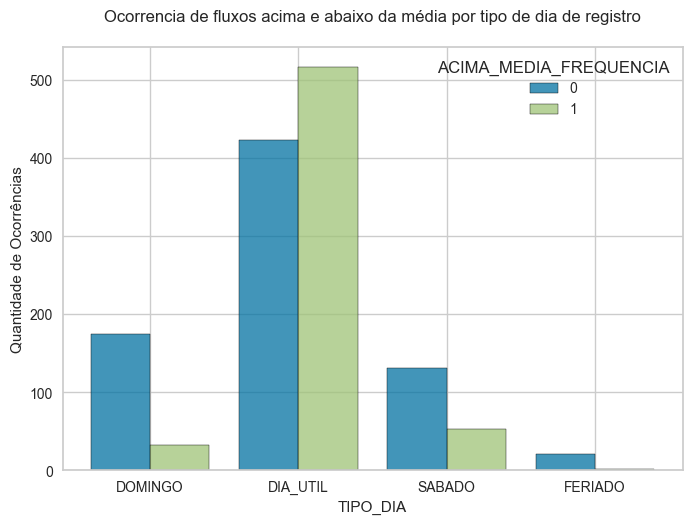

In [16]:
plt.clf()
grafico = sns.histplot(data=base, x="TIPO_DIA", hue="ACIMA_MEDIA_FREQUENCIA", multiple="dodge", shrink=0.8)
grafico.set_title(f'Ocorrencia de fluxos acima e abaixo da média por tipo de dia de registro\n'); 
grafico.set_ylabel('Quantidade de Ocorrências'); 
plt.show()

Para observar em apenas um gráfico como as variáveis predecessoras influenciam na variável alvo (ACIMA_MEDIA_FREQUENCIA), foi construído um gráfico do tipo "scatter_matrix" onde pode ser visto abaixo.
No gráfico é possível observar que algumas variáveis influenciam mais no fato do fluxo de motocicleta ficarem acima ou abaixo da média. O Tipo de dia quando comparado com a hora gera uma visualização gráfica bastante heterogênica quanto a variável alvo, é possível perceber tipos de dias e horários em que o fluxo de motocicletas fica acima e abaixo da média. Por outro lado os dados climáticos não se mostram fontes de gráficos com bons contrastes, principalmente quando analisada somente a precipitação.
Como às variáveis predecessoras se originam das bases de dados climáticos e tipos de dia e horários, optou-se por fazer a mesma análise para suas respectivas variáveis, colocando em um grupo os dados de horário e de tipo de dia e em outro grupo os dados climáticos.


In [17]:
grafico = px.scatter_matrix(base, dimensions=['TIPO_DIA', 'PRECIPITACAO','TEMPERATURA','HORA'], color = 'ACIMA_MEDIA_FREQUENCIA')
grafico.show()

#### 4.2.1 - Exploração dos dados climáticos

Para analisar apenas como os dados climáticos influenciam na variável alvo, um gráfico do tipo "scatter_matrix" foi construído e pode-se observar que a variável de temperatura apresenta uma certa tendência a influenciar no fluxo de motocicletas, pode ser visto no gráfico um bom contraste entre as amostras acima da média e abaixo da média de fluxo, mostrando que para temperaturas mais altas o fluxo de motocicletas fica acima da média e para temperaturas mais baixas, abaixo da média. Já os dados de precipitação aparentemente não mostram uma heterogeneidade quanto à variável alvo, mostrando que tanto para precipitações altas e baixas temos fluxos de motocicletas altos e baixos, o que nos leva a crer que independente da precipitação, a maioria dos motociclistas não deixam de utilizar suas motos.
A temperatura por sua vez pode carregar as informações do horário, onde as madrugadas que tendem a ter menos fluxo de motocicletas também tendem a ser mais frias.


In [18]:
grafico = px.scatter_matrix(base, dimensions=['TEMPERATURA','PRECIPITACAO'], color = 'ACIMA_MEDIA_FREQUENCIA')
grafico.show()

#### 4.2.2 - Exploração dos Dados de Horário e Tipo de Dias

De acordo com o gráfico "scatter_matrix" construído para os dados de tipo de dia e hora pode-se concluir que essas variáveis conseguem descrever de forma mais precisa os fluxos de motocicletas no ponto estudado, já que no cruzamentos das duas variáveis pode-se observar um alto contraste entre os fluxos acima da média (em amarelo) e abaixo da média (em azul). Desse gráfico consegue-se observar que em dias úteis, os fluxos de motocicletas tendem a ser maiores que a média das 10h até às 20h enquanto finais de semana e no feriado a tendência é ser menor dependendo do horário. Outra observação interessante é que o fluxo de motocicletas no sábado durante o horário próximo do meio dia é alta, o que pode ser explicado pela atividade comercial normal da cidade que tende a se encerrar em torno deste horário.

In [19]:
grafico = px.scatter_matrix(base, dimensions=['TIPO_DIA','HORA'], color = 'ACIMA_MEDIA_FREQUENCIA')
grafico.show()

### 4.3 - Exploração dos Dados com Enfoque na Classe Álvo

Como a variável HORA apresentou-se na análise anterior a mais significativa para a influenciar se existirá um fluxo de motocicletas acima ou abaixo da média, tanto os dados de tipo de dia quanto dados climáticos foram exibidos e analisados com relação a variável HORA.

#### 4.3.1 - Analisando Dados de Tipo de Dia e Horário

Na análise dos dados de tipo de dia e horário, assim como na análise dos gráficos "scater_matrix" pode-se perceber que a maior ocorrência de altos fluxos de motocicletas ocorrem em dias úteis, onde inicia-se sua intensificação às 10 horas da manhã, chegando até às 20h, provavelmente se dá pelas atividades normais de transporte de pessoas e trabalhadores que utilizam motocicletas em seus trabalhos (atividades comerciais). No sábado percebe-se um aumento de fluxo das 11h até às 14h, horário em que costuma diminuir a intensidade das atividades comerciais neste dia, observou-se também ocorrência de fluxos acima da média das 17 às 22h. O dia de domingo mostra um comportamento parecido com o sábado, porém no horário do almoço o fluxo se mostra menor que no sábado, provavelmente influenciado por menos atividade comercial neste horário no domingo que no sábado, já que no sábado existem mais comércios em funcionamento neste horário.
Nos finais de semana também é percebendo tanto no sábado quando no domingo um aumento de fluxo mais para o fim do dia, variando de 17h às 22h, como são horários em que a atividade comercial é baixa, pode-se atribuir esse aumento de fluxo pela utilização das motocicletas para transporte pessoal. O Feriado, diferente de todos os outros dias, apresenta baixo fluxo de motocicletas, apenas registrando fluxo mais alto às 14h e às 18h.


C:\Users\Joao\AppData\Local\Temp\ipykernel_7468\2218200867.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Figure size 800x550 with 0 Axes>

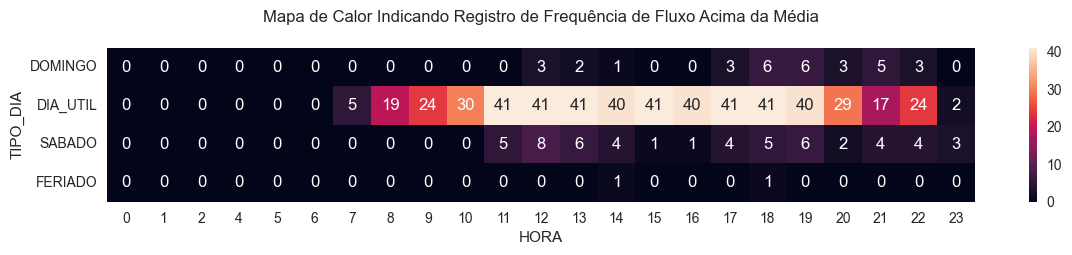

In [158]:
def plota_heatmap_1(rotulo_y, rotulo_x, rotulo_preenchimento, foco_preenchimento, largura = 5, altura = 5, titulo =''):
    plt.clf()
    df = base.loc[:, [rotulo_y, rotulo_x, rotulo_preenchimento]]
    colunas = df[rotulo_x].unique()
    indices = df[rotulo_y].unique()
    mapa = pd.DataFrame(columns=colunas, index = indices)
    for i in mapa.columns:
        for j in mapa.index:
            mapa[i][j] = pd.to_numeric(df.loc[df[rotulo_y]==j].loc[df[rotulo_x]==i].loc[df[rotulo_preenchimento] == foco_preenchimento].shape[0])
        mapa[i] = pd.to_numeric(mapa[i],errors = 'coerce')
    plt.figure(figsize = (largura, altura))
    grafico = sns.heatmap(mapa, annot=True, linewidths=0)
    grafico.set_title(f'{titulo}\n')
    grafico.set_ylabel(rotulo_y);
    grafico.set_xlabel(rotulo_x); 
    plt.show()
plota_heatmap_1('TIPO_DIA', 'HORA', 'ACIMA_MEDIA_FREQUENCIA', 1, 14, 2, 'Mapa de Calor Indicando Registro de Frequência de Fluxo Acima da Média')

#### 4.3.1 - Analisando Dados de Clima

Para a análise dos dados climáticos, como existem poucos registros de precipitações, criou-se uma variável categórica nominal de nome 'PRECIPITACAO_CATEGORICO', que foi preenchida com a informação 'CHOVE' e 'NAO_CHOVE' a fim de indicar se naquele horário havia alguma chuva ou não. Desta maneira ficou mais fácil perceber se a variável 'PRECIPITACAO' possui alguma influência no fluxo de motocicletas no ponto estudado.
Apesar de poucos dados de dias chuvosos, o que percebeu-se que com chuva ou sem chuva, a tendência de aumento ou diminuição do fluxo de motocicletas permanecem os mesmos, já que ocorrem aumentos de fluxos, dadas as devidas proporções, nos mesmos horários tanto com chuva quanto sem chuva. Logo, percebe-se que apesar de chover, quem utiliza motocicletas para transporte ou trabalho, não deixa de utiliza-las.


C:\Users\Joao\AppData\Local\Temp\ipykernel_7468\428330881.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Figure size 800x550 with 0 Axes>

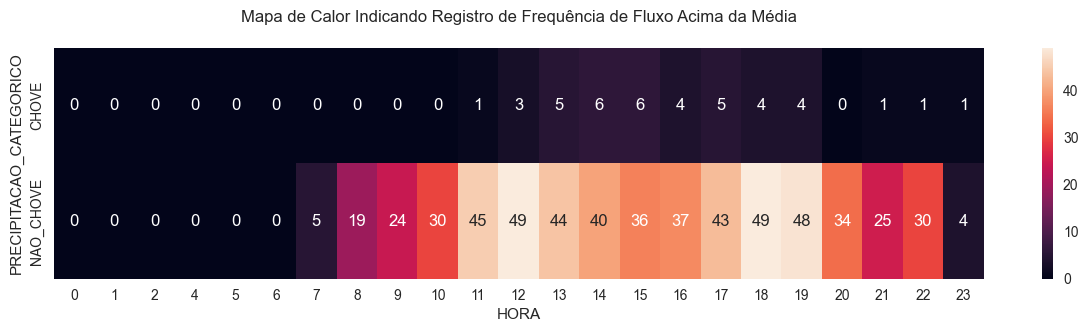

In [159]:
def plota_heatmap_2(rotulo_y, rotulo_x, rotulo_preenchimento, foco_preenchimento, largura = 5, altura = 5, titulo =''):
    plt.clf()
    base[rotulo_x] = base[rotulo_x].apply(lambda x : round(int(x)))
    base['PRECIPITACAO_CATEGORICO'] = base[rotulo_y].apply(lambda x : "NAO_CHOVE" if x == 0.0 else "CHOVE")
    rotulo_y = 'PRECIPITACAO_CATEGORICO'
    df = base.loc[:, [rotulo_y, rotulo_x, rotulo_preenchimento]]
    colunas = sorted(df[rotulo_x].unique())
    indices =  sorted(df[rotulo_y].unique())
    mapa = pd.DataFrame(columns=colunas, index = indices)
    for i in mapa.columns:
        for j in mapa.index:
            mapa[i][j] = pd.to_numeric(df.loc[df[rotulo_y]==j].loc[df[rotulo_x]==i].loc[df[rotulo_preenchimento] == foco_preenchimento].shape[0])
        mapa[i] = pd.to_numeric(mapa[i],errors = 'coerce')
    plt.figure(figsize = (largura, altura))
    grafico = sns.heatmap(mapa, annot=True, linewidths=0)
    grafico.set_title(f'{titulo}\n')
    grafico.set_ylabel(rotulo_y);
    grafico.set_xlabel(rotulo_x); 
    plt.show()
plota_heatmap_2('PRECIPITACAO', 'HORA', 'ACIMA_MEDIA_FREQUENCIA', 1, 15, 3, 'Mapa de Calor Indicando Registro de Frequência de Fluxo Acima da Média')

Agora analisando a temperatura com relação ao horário, o que percebe-se no gráfico a baixo que a temperatura se correlaciona com o horário, já que as noites são mais frias que os dias e por sua vez, as informações de fluxos de motocicletas que estão acima e a baixo da sua média varia de forma ordenada com a temperatura pois esta está diretamente influenciada pelo horário que por sua vez, influencia diretamente no aumento ou de munição dos fluxos de motocicletas.

C:\Users\Joao\AppData\Local\Temp\ipykernel_7468\3203548154.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Figure size 800x550 with 0 Axes>

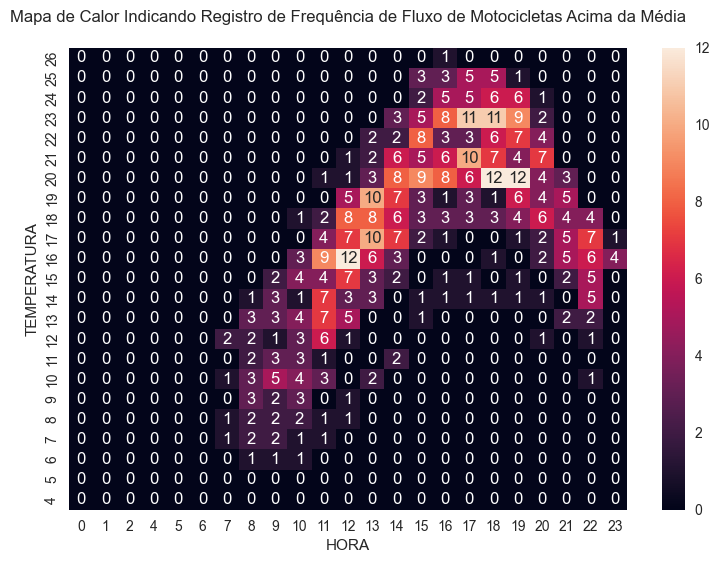

In [161]:
def plota_heatmap_3(rotulo_y, rotulo_x, rotulo_preenchimento, foco_preenchimento, largura = 5, altura = 5, titulo =''):
    plt.clf()
    base[rotulo_x] = base[rotulo_x].apply(lambda x : round(x))
    base[rotulo_y] = base[rotulo_y].apply(lambda y : round(y))
    df = base.loc[:, [rotulo_y, rotulo_x, rotulo_preenchimento]]
    colunas = sorted(df[rotulo_x].unique())
    indices =  sorted(df[rotulo_y].unique(), reverse=True)
    mapa = pd.DataFrame(columns=colunas, index = indices)
    for i in mapa.columns:
        for j in mapa.index:
            mapa[i][j] = pd.to_numeric(df.loc[df[rotulo_y]==j].loc[df[rotulo_x]==i].loc[df[rotulo_preenchimento] == foco_preenchimento].shape[0])
        mapa[i] = pd.to_numeric(mapa[i],errors = 'coerce')
    plt.figure(figsize = (largura, altura))
    grafico = sns.heatmap(mapa, annot=True, linewidths=0)
    grafico.set_title(f'{titulo}\n')
    grafico.set_ylabel(rotulo_y);
    grafico.set_xlabel(rotulo_x); 
    plt.show()
plota_heatmap_3('TEMPERATURA', 'HORA', 'ACIMA_MEDIA_FREQUENCIA', 1, 9, 6, 'Mapa de Calor Indicando Registro de Frequência de Fluxo de Motocicletas Acima da Média')

# 5 - Criação do Modelo de Machine Learning

Como a análise dos dados foi de certa forma separada em dados de tipo de dias e horários e dados climáticos, na etapa da criação do modelo de machine learning não foi diferente. Foram feitas e avaliadas três configurações diferentes dos dados para a realização do treinamento do modelo e em cada configuração foram selecionados três algoritmos a fim de avaliar qual apresenta o melhor desempenho. Esquema:
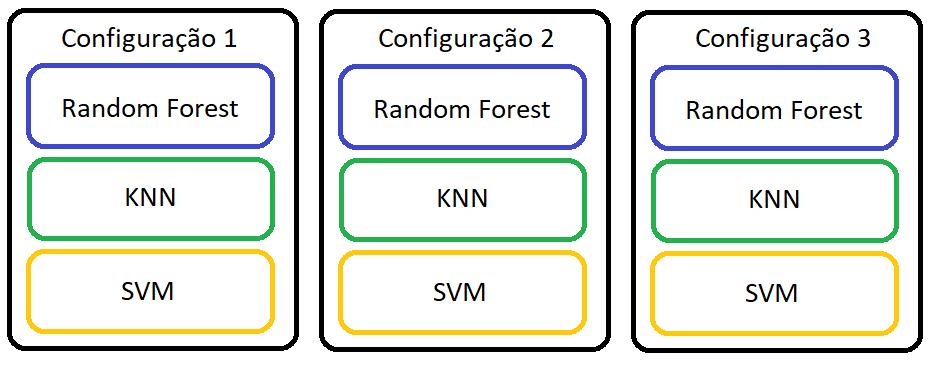
A configurações de dados ficaram da seguinte forma:
* Configuração 1 - Dados de fluxo de motocicletas, dados climáticos e dados de tipo de dia e horário
* Configuração 2 - Dados de fluxo de motocicletas e dados climáticos
* Configuração 3 - Dados de fluxo de motocicletas e dados de tipo de dia e horário

Dessa forma, se tornou possível avaliar através do desempenho dos modelos quais conjuntos de dados influenciam mais ou menos em fluxos altos ou baixos de motocicletas no ponto estudado da cidade de Belo Horizonte estudado.

Em todas as 3 configurações, foram utilizadas estratégias de otimização (model tuning) e por fim a validação cruzada. 

Para a otimização dos parâmetros de configurações dos algoritmos, utilizou-se a GridSearchCV do pacote sklearn e para a validação cruzada utilizou-se o kfold do pacote sklearn. Para a validação cruzada, optou-se por fazer 30 vezes o teste de validação cruzada com o kfold e depois calculou-se uma média dos resultados para cada algoritmo. No final da execução de todos os testes, os resultados foram apresentados em uma tabela e em gráficos para melhorar a capacidade de interpretação e análise.


## 5.1 Construindo Modelos de Machine Learning com Dados de Fluxo de Motocicletas, Dados Climáticos, Tipo de Dia e Horário (Configuração 1)

Leitura dos dados da memória:

In [198]:
base_ml = pd.read_csv('dados/fluxo_moto/base_fluxo_motos_tratada.csv')
base_ml

HORA  TIPO_DIA  PRECIPITACAO  TEMPERATURA  ACIMA_MEDIA_FREQUENCIA
0        0   DOMINGO           0.0         15.8                       0
1        1   DOMINGO           0.0         15.1                       0
2        2   DOMINGO           0.0         14.7                       0
3        4   DOMINGO           0.0         14.4                       0
4        5   DOMINGO           0.0         14.0                       0
...    ...       ...           ...          ...                     ...
1348    19  DIA_UTIL           0.0         23.2                       1
1349    20  DIA_UTIL           0.0         21.8                       1
1350    21  DIA_UTIL           0.0         17.3                       0
1351    22  DIA_UTIL           0.0         14.3                       0
1352    23  DIA_UTIL           0.0         13.5                       0

[1353 rows x 5 columns]

A conversão da variável categórica TIPO_DIA em variáveis numéricas discretas foi feita com a finalidade de preparar os dados para serem submetidos ao algoritmos.

In [199]:
base_ml = pd.get_dummies(base_ml)
base_ml

HORA  PRECIPITACAO  TEMPERATURA  ACIMA_MEDIA_FREQUENCIA  \
0        0           0.0         15.8                       0   
1        1           0.0         15.1                       0   
2        2           0.0         14.7                       0   
3        4           0.0         14.4                       0   
4        5           0.0         14.0                       0   
...    ...           ...          ...                     ...   
1348    19           0.0         23.2                       1   
1349    20           0.0         21.8                       1   
1350    21           0.0         17.3                       0   
1351    22           0.0         14.3                       0   
1352    23           0.0         13.5                       0   

      TIPO_DIA_DIA_UTIL  TIPO_DIA_DOMINGO  TIPO_DIA_FERIADO  TIPO_DIA_SABADO  
0                     0                 1                 0                0  
1                     0                 1                 0                0  
2                     0                 1                 0                0  
3                     0                 1                 0                0  
4                     0                 1                 0                0  
...                 ...               ...               ...              ...  
1348                  1                 0                 0                0  
1349                  1                 0                 0                0  
1350                  1                 0                 0                0  
1351                  1                 0                 0                0  
1352                  1                 0                 0                0  

[1353 rows x 8 columns]

In [200]:
X = base_ml.drop('ACIMA_MEDIA_FREQUENCIA', axis=1)
y = base_ml['ACIMA_MEDIA_FREQUENCIA']

### 5.1.1 - Balanceando a base (Oversampling)

A variável alvo ACIMA_MEDIA_FREQUENCIA encontra-se levemente desbalanceada, contando com 750 registros onde o fluxo de motocicletas no ponto de estudo foram abaixo da média e 603 acima da média. Ao utilizar a estratégia de oversamplig (SMOTE) foram geradas amostras sintéticas da variável alvo minoritária, o que no final balanceou a base contando com 750 registros de cada classe.

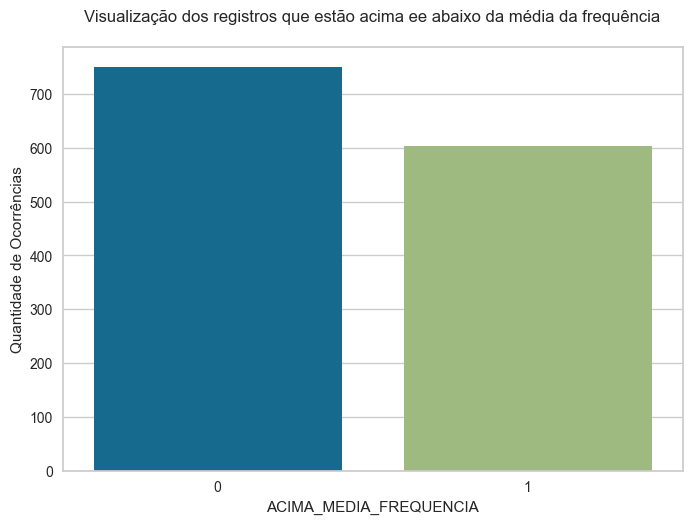

In [201]:
plt.clf()
grafico = sns.countplot(x=y)
grafico.set_ylabel('Quantidade de Ocorrências'); 
grafico.set_title(f'Visualização dos registros que estão acima ee abaixo da média da frequência\n'); 
plt.show()

In [202]:
np.unique(y, return_counts = True) 

(array([0, 1], dtype=int64), array([750, 603], dtype=int64))

Balanceando o modelo:

In [203]:
smote = SMOTE(sampling_strategy='minority')
X, y = smote.fit_resample(X, y)

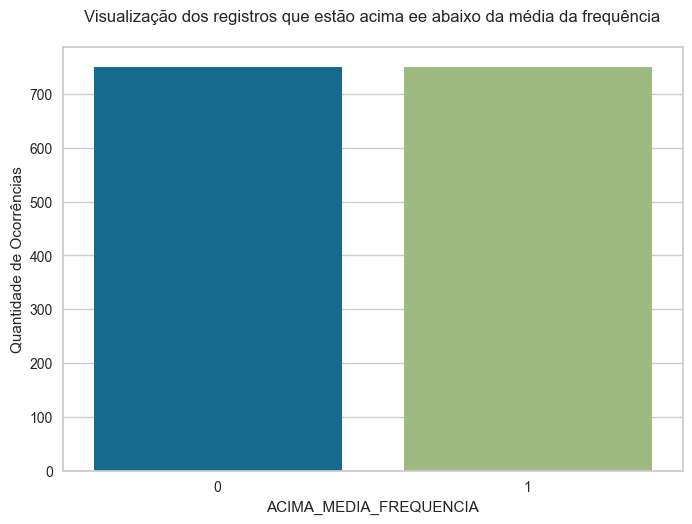

In [204]:
plt.clf()
grafico = sns.countplot(x=y)
grafico.set_ylabel('Quantidade de Ocorrências'); 
grafico.set_title(f'Visualização dos registros que estão acima ee abaixo da média da frequência\n'); 
plt.show()

In [205]:
np.unique(y, return_counts = True) 

(array([0, 1], dtype=int64), array([750, 750], dtype=int64))

### 5.1.2 - Escalodando dados

Foi realizado o escalonamento das variáveis predecessoras com o objetivo de não proporcionar a influência incorreta de valores mais altos nos modelos.

In [206]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X

array([[0.        , 0.        , 0.5520362 , ..., 1.        , 0.        ,
        0.        ],
       [0.04347826, 0.        , 0.52036199, ..., 1.        , 0.        ,
        0.        ],
       [0.08695652, 0.        , 0.50226244, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.73913043, 0.        , 0.80544211, ..., 0.        , 0.        ,
        0.        ],
       [0.30434783, 0.        , 0.14701289, ..., 0.        , 0.        ,
        0.        ],
       [0.69565217, 0.        , 0.77385761, ..., 0.        , 0.        ,
        1.        ]])

### 5.1.3 - Executando o Majority Learner para Ter um Nível de Acurácia de Referência

Com o objetivo de se obter uma limite mínimo aceitável de desempenho dos algoritmos, foi feito um treinamento utilizando o algoritmo majority learner na base desbalanceada, fazendo o aprendizado pela maioria. Utilizando a métrica de avaliação de acurácia, obteve-se 55% de taxa de acertos, indicando assim que qualquer outro algoritmo que ficar abaixo dessa taxa de acertos é melhor classificar como a classe alvo de maior ocorrência.

In [207]:
base_majority = Orange.data.Table('dados/fluxo_moto/base_fluxo_motos_tratada_regras.csv')

In [208]:
base_majority.domain

[FERIADO, DOMINGO, SABADO, DIA_UTIL, PRECIPITACAO, TEMPERATURA, HORA | ACIMA_MEDIA_FREQUENCIA]

In [209]:
majority = Orange.classification.MajorityLearner()

In [210]:
previsoes = Orange.evaluation.testing.TestOnTestData(base_majority, base_majority, [majority])

In [211]:
Orange.evaluation.CA(previsoes)

array([0.55432373])

### 5.1.4 - Fazendo o Tunning dos Parametros

#### 5.1.4.1 - Random Forest

In [193]:
parametros = {'criterion': ['gini', 'entropy'],
              'n_estimators': range(35, 45),
              'min_samples_split': range(2, 10),
              'min_samples_leaf': range(2, 10)}

In [194]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parametros)
grid_search.fit(X, y)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'criterion': 'entropy', 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 43}
0.8666666666666668


#### 5.1.4.2 - KNN

In [195]:
parametros = {'n_neighbors': [3, 5, 10, 20],
              'p': [1, 2],
             'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=parametros)
grid_search.fit(X, y)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 1}
0.8506666666666668


#### 5.1.4.3 - SVM - Suport Vector Machines

In [81]:
parametros = {'tol': [0.1, 0.01, 0.001, 0.0001, 0.00001],
              'random_state': [1,2,3,4,5,6],
              'C': [1.0, 1.5, 2.0],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

In [82]:
grid_search = GridSearchCV(estimator=SVC(), param_grid=parametros)
grid_search.fit(X, y)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'C': 1.5, 'kernel': 'rbf', 'random_state': 1, 'tol': 0.1}
0.844


### 5.1.5 - Avaliando Modelos com Cross-validation

#### 5.1.5.1 - Ramdom Forest

In [212]:
resultados_ramdom_forest = []
for i in range(30):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    random_forest = RandomForestClassifier(n_estimators=37, criterion='gini', min_samples_leaf= 5, min_samples_split= 4, random_state = 0)
    pontos = cross_val_score(random_forest, X, y, cv = kfold)
    resultados_ramdom_forest.append(pontos.mean())

In [213]:
df_resultados_ramdom_forest = pd.DataFrame(resultados_ramdom_forest,columns=['RESULTADOS_RANDOM_FOREST'])
df_resultados_ramdom_forest.describe()

RESULTADOS_RANDOM_FOREST
count                 30.000000
mean                   0.867378
std                    0.003697
min                    0.860000
25%                    0.865333
50%                    0.867333
75%                    0.869833
max                    0.876000

#### 5.1.5.2 - KNN

In [214]:
resultados_knn = []
for i in range(30):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    knn = KNeighborsClassifier(algorithm='brute', n_neighbors=10, metric='minkowski', p = 2)
    pontos = cross_val_score(knn, X, y, cv = kfold)
    resultados_knn.append(pontos.mean())

In [215]:
df_resultados_knn = pd.DataFrame(resultados_knn,columns=['RESULTADOS_KNN'])
df_resultados_knn.describe()

RESULTADOS_KNN
count       30.000000
mean         0.869089
std          0.004137
min          0.859333
25%          0.866333
50%          0.869667
75%          0.872000
max          0.878000

#### 5.1.5.3 - SVM

In [216]:
resultados_svm = []
for i in range(30):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    svm = SVC(kernel='rbf', random_state=1, C = 1.5, tol = 0.01)
    pontos = cross_val_score(svm, X, y, cv = kfold)
    resultados_svm.append(pontos.mean())

In [217]:
df_resultados_svm = pd.DataFrame(resultados_svm,columns=['RESULTADOS_SVM'])
df_resultados_svm.describe()

RESULTADOS_SVM
count       30.000000
mean         0.853689
std          0.002654
min          0.847333
25%          0.851500
50%          0.854000
75%          0.855333
max          0.858000

### 5.1.6- Agrupando tabelas de resultados

Na tabela abaixo foi apresentado os resultados médios da acurácia de cada algoritmo para a configuração 1 dos dados:

In [218]:
resultados = pd.DataFrame({'RANDOM_FOREST': resultados_ramdom_forest, 'KNN': resultados_knn, 'SVM': resultados_svm})
resultados.describe()

RANDOM_FOREST        KNN        SVM
count      30.000000  30.000000  30.000000
mean        0.867378   0.869089   0.853689
std         0.003697   0.004137   0.002654
min         0.860000   0.859333   0.847333
25%         0.865333   0.866333   0.851500
50%         0.867333   0.869667   0.854000
75%         0.869833   0.872000   0.855333
max         0.876000   0.878000   0.858000

Medindo Porcentagem de Variação

In [219]:
(resultados.std() / resultados.mean())*100

RANDOM_FOREST    0.426237
KNN              0.476064
SVM              0.310840
dtype: float64

## 5.2 - Construindo Modelos de Machine Learning com Dados de Fluxo de Motocicletas e Dados Climáticos (Configuração 2)

As mesmas tarefas que foram feitas para a configuração 1. Foram feitas para a configuração 2 e 3, porém concentrou-se o código em apenas uma célula a fim de obter de imediato a tabela com o resultado dos três algoritmos.

In [220]:
#Recupera e trata colunas da base
base_ml = pd.read_csv('dados/fluxo_moto/base_fluxo_motos_tratada.csv')
base_ml = base_ml.drop(['TIPO_DIA', 'HORA'], axis=1)

#Separa a classe alvo
X = base_ml.drop('ACIMA_MEDIA_FREQUENCIA', axis=1)
y = base_ml['ACIMA_MEDIA_FREQUENCIA']

#Escalona os dados
scaler = StandardScaler()
X = scaler.fit_transform(X)

#Faz o tunning dos parametros
# -> Random Forest
parametros = {'criterion': ['gini', 'entropy'],
              'n_estimators': range(38, 41),
              'min_samples_split': range(6, 10),
              'min_samples_leaf': range(6, 10)}
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parametros)
grid_search.fit(X, y)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print("==========================\n Tunning Random Forest\n==========================")
print(melhores_parametros)
print(melhor_resultado)
# -> Random KNN
parametros = {'n_neighbors': [20,25,30,35,40],
              'p': [1, 2],
              'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=parametros)
grid_search.fit(X, y)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print("==========================\n     Tunning KNN\n==========================")
print(melhores_parametros)
print(melhor_resultado)
# -> Random SVM
parametros = {'tol': [0.1, 0.01, 0.001, 0.0001, 0.00001],
              'random_state': [1,2,3,4,5,6],
              'C': [0.5, 1.0, 1.5, 2.0],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
grid_search = GridSearchCV(estimator=SVC(), param_grid=parametros)
grid_search.fit(X, y)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print("==========================\n     Tunning SVM\n==========================")
print(melhores_parametros)
print(melhor_resultado)

# Avaliacao dos algoritimos com cross-validation
resultados_ramdom_forest = []
for i in range(30):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    random_forest = RandomForestClassifier(n_estimators=38, criterion='entropy', min_samples_leaf= 9, min_samples_split=9, random_state = 0)
    pontos = cross_val_score(random_forest, X, y, cv = kfold)
    resultados_ramdom_forest.append(pontos.mean())
    
resultados_knn = []
for i in range(30):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    knn = KNeighborsClassifier(algorithm='auto', n_neighbors=35, metric='minkowski', p = 2)
    pontos = cross_val_score(knn, X, y, cv = kfold)
    resultados_knn.append(pontos.mean())
    
resultados_svm = []
for i in range(30):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    svm = SVC(kernel='linear', random_state=1, C = 0.5, tol = 0.1)
    pontos = cross_val_score(svm, X, y, cv = kfold)
    resultados_svm.append(pontos.mean())
resultados_dados_climaticos = pd.DataFrame({'RANDOM_FOREST': resultados_ramdom_forest, 'KNN': resultados_knn, 'SVM': resultados_svm})
resultados_dados_climaticos.describe()

 Tunning Random Forest
{'criterion': 'entropy', 'min_samples_leaf': 9, 'min_samples_split': 6, 'n_estimators': 38}
0.72359983599836
     Tunning KNN
{'algorithm': 'auto', 'n_neighbors': 35, 'p': 2}
0.7169577695776959
     Tunning SVM
{'C': 0.5, 'kernel': 'linear', 'random_state': 1, 'tol': 0.1}
0.72063413967473


RANDOM_FOREST        KNN        SVM
count      30.000000  30.000000  30.000000
mean        0.721135   0.709701   0.723716
std         0.004671   0.004587   0.002207
min         0.712440   0.699940   0.718410
25%         0.718603   0.707296   0.722108
50%         0.722108   0.709499   0.723573
75%         0.724080   0.712288   0.725027
max         0.729597   0.720605   0.729461

## 5.3 - Construindo Modelos de Machine Learning com Dados de Fluxo de Motocicletas e Dados de Tipo de Dia e Hora (Configuração 3)

In [221]:
#Recupera e trata colunas da base
base_ml = pd.read_csv('dados/fluxo_moto/base_fluxo_motos_tratada.csv')
base_ml = base_ml.drop(['PRECIPITACAO', 'TEMPERATURA'], axis=1)
base_ml = pd.get_dummies(base_ml)

#Separa a classe alvo
X = base_ml.drop('ACIMA_MEDIA_FREQUENCIA', axis=1)
y = base_ml['ACIMA_MEDIA_FREQUENCIA']

#Escalona os dados
scaler = StandardScaler()
X = scaler.fit_transform(X)

#Faz o tunning dos parametros
# -> Random Forest
parametros = {'criterion': ['gini', 'entropy'],
              'n_estimators': range(35, 45),
              'min_samples_split': range(2, 10),
              'min_samples_leaf': range(8, 10)}
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parametros)
grid_search.fit(X, y)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print("==========================\n Tunning Random Forest\n==========================")
print(melhores_parametros)
print(melhor_resultado)
# -> Random KNN
parametros = {'n_neighbors': [10,15,20,25,30,35,40],
              'p': [1, 2],
              'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=parametros)
grid_search.fit(X, y)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print("==========================\n     Tunning KNN\n==========================")
print(melhores_parametros)
print(melhor_resultado)
# -> Random SVM
parametros = {'tol': [0.1, 0.01, 0.001, 0.0001, 0.00001],
              'random_state': [1,2,3,4,5,6],
              'C': [0.5, 1.0, 1.5, 2.0],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
grid_search = GridSearchCV(estimator=SVC(), param_grid=parametros)
grid_search.fit(X, y)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print("==========================\n     Tunning SVM\n==========================")
print(melhores_parametros)
print(melhor_resultado)

# Avaliacao dos algoritimos com cross-validation
resultados_ramdom_forest = []
for i in range(30):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    random_forest = RandomForestClassifier(n_estimators=40, criterion='gini', min_samples_leaf=9 , min_samples_split= 5, random_state = 0)
    pontos = cross_val_score(random_forest, X, y, cv = kfold)
    resultados_ramdom_forest.append(pontos.mean())
    
resultados_knn = []
for i in range(30):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    knn = KNeighborsClassifier(algorithm='auto', n_neighbors=20, metric='minkowski', p = 1)
    pontos = cross_val_score(knn, X, y, cv = kfold)
    resultados_knn.append(pontos.mean())
    
resultados_svm = []
for i in range(30):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    svm = SVC(kernel='rbf', random_state=1, C = 0.5, tol = 0.1)
    pontos = cross_val_score(svm, X, y, cv = kfold)
    resultados_svm.append(pontos.mean())
resultados_dados_dia_hora = pd.DataFrame({'RANDOM_FOREST': resultados_ramdom_forest, 'KNN': resultados_knn, 'SVM': resultados_svm})
resultados_dados_dia_hora.describe()

 Tunning Random Forest
{'criterion': 'gini', 'min_samples_leaf': 8, 'min_samples_split': 7, 'n_estimators': 37}
0.8654776547765477
     Tunning KNN
{'algorithm': 'auto', 'n_neighbors': 20, 'p': 1}
0.8595517288506219
     Tunning SVM
{'C': 0.5, 'kernel': 'rbf', 'random_state': 1, 'tol': 0.1}
0.8492196255295885


RANDOM_FOREST        KNN        SVM
count      30.000000  30.000000  30.000000
mean        0.870188   0.860108   0.849047
std         0.003490   0.003388   0.000942
min         0.860991   0.855866   0.844063
25%         0.868433   0.857356   0.849201
50%         0.869894   0.859529   0.849218
75%         0.873227   0.863069   0.849237
max         0.875855   0.867707   0.849270

# 6 - Interpretação de Resultados

Para interpretar os resultados, utilizou-se as três tabelas de resultados construídas anteriormente, uma para cada configuração de dados. De forma gráfica, comparou-se as médias e desvios padrões de cada configuração chegando a alguns insights.

## 6.1 - Apresentação das Três Configurações de Modelos de Machine Learning

In [222]:
print("==============================================================================")
print("Dados Fluxo + Dados Clima + Dados de Tipos de Dias e Horários")
print("==============================================================================")
print(resultados.describe())
print("..............................................................................")
print(" ")
print("==============================================================================")
print("Dados Fluxo + Dados Clima")
print("==============================================================================")
print(resultados_dados_climaticos.describe())
print("..............................................................................")
print(" ")
print("==============================================================================")
print("Dados Fluxo + Dados de Tipos de Dias e Horários")
print("==============================================================================")
print(resultados_dados_dia_hora.describe())

Dados Fluxo + Dados Clima + Dados de Tipos de Dias e Horários
       RANDOM_FOREST        KNN        SVM
count      30.000000  30.000000  30.000000
mean        0.867378   0.869089   0.853689
std         0.003697   0.004137   0.002654
min         0.860000   0.859333   0.847333
25%         0.865333   0.866333   0.851500
50%         0.867333   0.869667   0.854000
75%         0.869833   0.872000   0.855333
max         0.876000   0.878000   0.858000
..............................................................................
 
Dados Fluxo + Dados Clima
       RANDOM_FOREST        KNN        SVM
count      30.000000  30.000000  30.000000
mean        0.721135   0.709701   0.723716
std         0.004671   0.004587   0.002207
min         0.712440   0.699940   0.718410
25%         0.718603   0.707296   0.722108
50%         0.722108   0.709499   0.723573
75%         0.724080   0.712288   0.725027
max         0.729597   0.720605   0.729461
.........................................................

### 6.1.1 - Visualização Gráfica das Médias Aritiméticas

Para construção do gráfico comparativo das médias das acurácias de cada algoritmo, foi necessário unir os datasets em apenas um e com um formato específico, possibilitando plotar as médias de cada algoritmo em cada configuração lado a lado.

In [223]:
dados_medias = {'ALGORITMO': ['Random Forest','Random Forest','Random Forest', 'KNN', 'KNN', 'KNN', 'SVM', 'SVM', 'SVM'],
                'CONFIGURACAO': ['Configuração 1','Configuração 2','Configuração 3','Configuração 1','Configuração 2','Configuração 3','Configuração 1','Configuração 2','Configuração 3'],
                'MEDIA': [resultados.describe()['RANDOM_FOREST']['mean'],resultados_dados_climaticos.describe()['RANDOM_FOREST']['mean'],resultados_dados_dia_hora.describe()['RANDOM_FOREST']['mean'],
                         resultados.describe()['KNN']['mean'],resultados_dados_climaticos.describe()['KNN']['mean'],resultados_dados_dia_hora.describe()['KNN']['mean'],
                         resultados.describe()['SVM']['mean'],resultados_dados_climaticos.describe()['SVM']['mean'],resultados_dados_dia_hora.describe()['SVM']['mean']]}
df_medias = pd.DataFrame(dados_medias)

<Figure size 800x550 with 0 Axes>

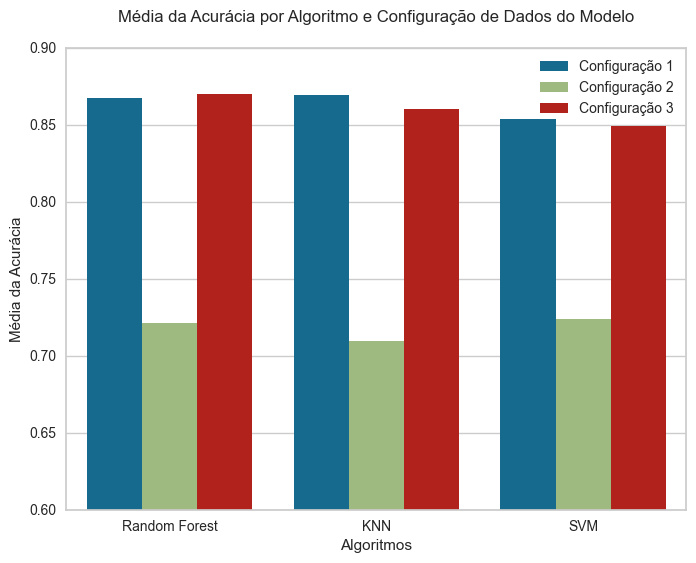

In [224]:
plt.clf()
plt.figure(figsize = (8, 6))
grafico = sns.barplot(data=df_medias, x="ALGORITMO", y="MEDIA", hue="CONFIGURACAO")
grafico.set_title(f'Média da Acurácia por Algoritmo e Configuração de Dados do Modelo\n'); 
grafico.set_ylabel('Média da Acurácia');
grafico.set_xlabel('Algoritmos');
plt.legend(loc='upper right')
plt.ylim(0.6, 0.9)
plt.show()

No gráfico acima conseguimos perceber que a configuração que teve o pior desempenho foi a configuração 2, ou seja, os dados de climáticos sozinhos são os que menos conseguem ser utilizados para prever um alto ou baixo fluxo de motocicletas no ponto de estudo. Já a configuração 1 e 3 foram as que tiveram melhores desempenho, valendo ressaltar que conter dados de clima no modelo de classificação de intensidade de fluxo de motocicletas se faz pouco relevante para as previsões. Mas o que explica os dados de clima ainda se mostrarem melhor que o majority learner? Provavelmente as informações de temperatura carregam em si as informações do horário, já que foi possível visualizar graficamente que a temperatura varia conforme o horário, assim, dependendo da temperatura, pode-se estimar se está em um horário de pico de fluxo ou não. 
Logo pode-se tirar como conhecimento dessa análise que o clima, ao contrário do que se esperava, tem baixa influência no aumento de fluxo de motocicletas no trânsito de motocicletas no ponto de estudo da cidade de Belo Horizonte, enquanto os tipos de dias e horários são os fatores que mais influenciam em um alto ou baixo fluxo de motocicletas.
Percebe-se também que o algoritmo random forest tem melhor desempenho para a configuração 3, onde há menos quantidades de informações, enquanto o algoritmo KNN tem melhor desempenho na configuração 1.


### 6.1.1 - Visualização Gráfica dos Desvio Padrões

Assim como para a construção do gráfico comparativo das médias de acurária, construiu-se o gráfico comparativo para os desvios padrões das acurácias.

In [225]:
dados_desvio_padrao = {'ALGORITMO': ['Random Forest','Random Forest','Random Forest', 'KNN', 'KNN', 'KNN', 'SVM', 'SVM', 'SVM'],
                'CONFIGURACAO': ['Configuração 1','Configuração 2','Configuração 3','Configuração 1','Configuração 2','Configuração 3','Configuração 1','Configuração 2','Configuração 3'],
                'DESVIO_PADRAO': [resultados.describe()['RANDOM_FOREST']['std'],resultados_dados_climaticos.describe()['RANDOM_FOREST']['std'],resultados_dados_dia_hora.describe()['RANDOM_FOREST']['std'],
                         resultados.describe()['KNN']['std'],resultados_dados_climaticos.describe()['KNN']['std'],resultados_dados_dia_hora.describe()['KNN']['std'],
                         resultados.describe()['SVM']['std'],resultados_dados_climaticos.describe()['SVM']['std'],resultados_dados_dia_hora.describe()['SVM']['std']]}
df_desvio_padrao = pd.DataFrame(dados_desvio_padrao)

<Figure size 800x550 with 0 Axes>

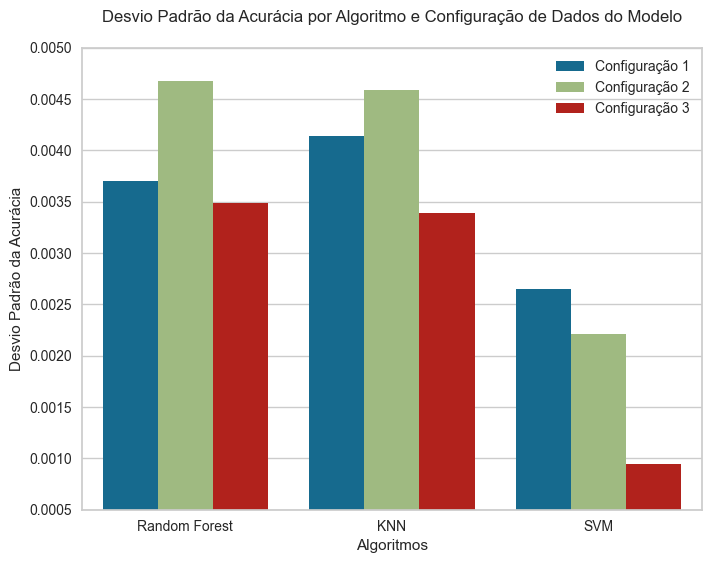

In [226]:
plt.clf()
plt.figure(figsize = (8, 6))
grafico = sns.barplot(data=df_desvio_padrao, x="ALGORITMO", y="DESVIO_PADRAO", hue="CONFIGURACAO")
grafico.set_title(f'Desvio Padrão da Acurácia por Algoritmo e Configuração de Dados do Modelo\n'); 
grafico.set_ylabel('Desvio Padrão da Acurácia');
grafico.set_xlabel('Algoritmos');
plt.legend(loc='upper right')
plt.ylim(0.0005, 0.005)
plt.show()

Ao analisar os desvios padrões, percebe-se que o algoritmo que menos varia sua acurácia quando submetido a várias configurações de bases de teste e treinamento é o SVM, porém este algoritmo foi o que apresentou menor acurácia média também. Quanto às configurações de dados, percebe-se que a configuração 3 torna os algoritmos com acurácias mais estáveis, levando a crer que os dados climáticos tendem a desestabilizar levemente os algoritmos de machine learning.

## 6.2 - Geração das Matrizes de Confusão para Cada Algoritmo Utilizando a Configuração 1

Para entender de forma mais geral os algoritmos e outras métricas além da acurácia e também perceber se os modelos erram mais quando tentam prever fluxos acima da média ou abaixo da média, construiu-se a matriz de confusão de cada modelo para a configuração 1 de dados.

### 6.2.1 Criando e Preparando Modelo

In [228]:
base_ml = pd.read_csv('dados/fluxo_moto/base_fluxo_motos_tratada.csv')
base_ml = pd.get_dummies(base_ml)
X = base_ml.drop('ACIMA_MEDIA_FREQUENCIA', axis=1)
y = base_ml['ACIMA_MEDIA_FREQUENCIA']
X, y = smote.fit_resample(X, y)
X = scaler.fit_transform(X)
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X, y, test_size = 0.15, random_state = 0)
X_treinamento.shape, y_treinamento.shape, X_teste.shape, y_teste.shape, X.shape, y.shape

((1275, 7), (1275,), (225, 7), (225,), (1500, 7), (1500,))

### 6.2.2 - Analizando Matriz de Confusão para o Algoritimo Random Forest

In [229]:
#{'criterion': 'entropy', 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 44}
random_forest = RandomForestClassifier(n_estimators=44, criterion='entropy', min_samples_leaf=4, min_samples_split=7, random_state=0)
random_forest.fit(X_treinamento, y_treinamento)

RandomForestClassifier(criterion='entropy', min_samples_leaf=4,
                       min_samples_split=7, n_estimators=44, random_state=0)

In [230]:
previsoes = random_forest.predict(X_teste)

In [231]:
accuracy_score(y_teste, previsoes)

0.8666666666666667

0.8666666666666667

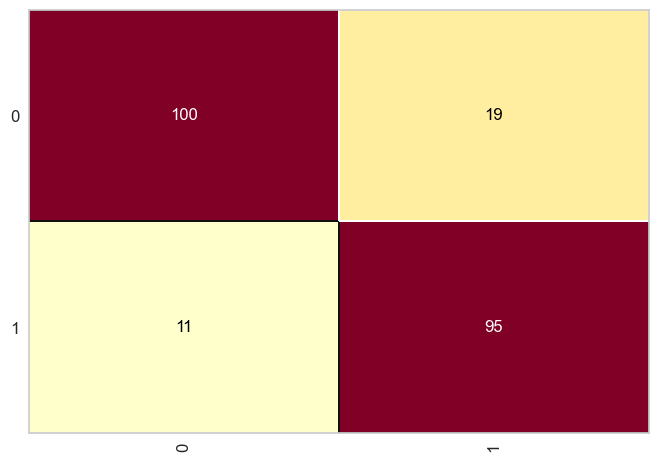

In [232]:
cm = ConfusionMatrix(random_forest)
cm.fit(X_treinamento, y_treinamento)
cm.score(X_teste, y_teste)

In [233]:
print(classification_report(y_teste, previsoes))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       119
           1       0.83      0.90      0.86       106

    accuracy                           0.87       225
   macro avg       0.87      0.87      0.87       225
weighted avg       0.87      0.87      0.87       225



A matiz de confusão mostra que o treinamento do algoritmo random forest aponta erradamente 18 casos de fluxos abaixo da média enquanto são acima da média e 8 casos de registros cima da média enquanto é abaixo da média. Classificar um registros como abaixo da média sendo acima da média é mais problemático que o oposto, já que fluxos altos de motocicletas no transito de maneira geral são piores que fluxos baixos.

### 6.2.3 - Analizando Matriz de Confusão para o Algoritimo KNN

In [234]:
#{'algorithm': 'brute', 'n_neighbors': 10, 'p': 2}
knn = KNeighborsClassifier(algorithm='brute', n_neighbors=10, metric='minkowski', p = 2)
knn.fit(X_treinamento, y_treinamento)

KNeighborsClassifier(algorithm='brute', n_neighbors=10)

In [235]:
previsoes = knn.predict(X_teste)

In [236]:
accuracy_score(y_teste, previsoes)

0.8355555555555556

0.8355555555555556

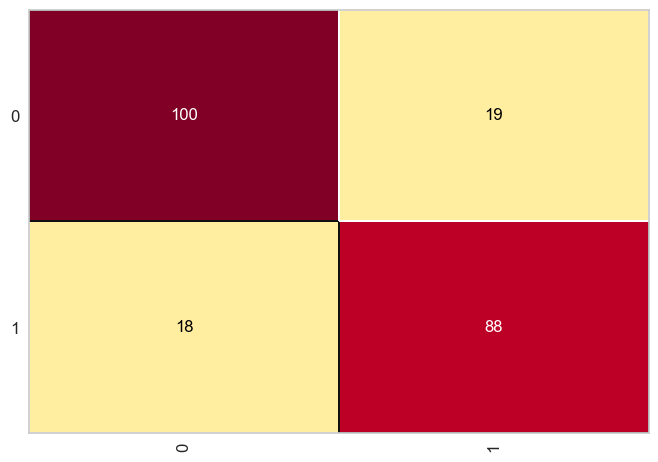

In [237]:
cm = ConfusionMatrix(knn)
cm.fit(X_treinamento, y_treinamento)
cm.score(X_teste, y_teste)

O Algoritimo KNN se mostra equilibrado quanto aos falsos positivos e falsos negativos, porém apresentando um valor maior de falsos negativos que o random forest.

In [238]:
print(classification_report(y_teste, previsoes))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       119
           1       0.82      0.83      0.83       106

    accuracy                           0.84       225
   macro avg       0.83      0.84      0.84       225
weighted avg       0.84      0.84      0.84       225



### 6.2.4 - Analizando Matriz de Confusão para o Algoritimo - Suport Vector Machines

In [123]:
#{'C': 1.5, 'kernel': 'rbf', 'random_state': 1, 'tol': 0.01}
svm = SVC(kernel='rbf', random_state=1, C = 1.5, tol = 0.01)
svm.fit(X_treinamento, y_treinamento)

SVC(C=1.5, random_state=1, tol=0.01)

In [124]:
previsoes = svm.predict(X_teste)

In [125]:
accuracy_score(y_teste, previsoes)

0.8222222222222222

0.8222222222222222

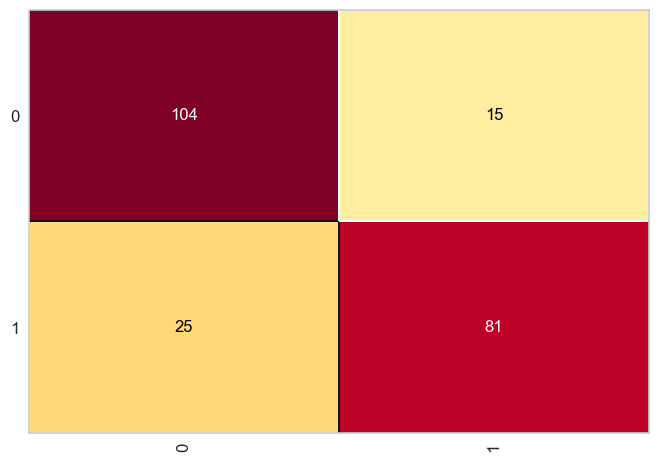

In [126]:
cm = ConfusionMatrix(svm)
cm.fit(X_treinamento, y_treinamento)
cm.score(X_teste, y_teste)

O algoritmo SVM além de apresentar a menor acurácia, foi o que apresentou maiores quantidades de falsos negativos, logo esse algoritmo é o que mais prevê um fluxo baixo de motocicletas enquanto o fluxo é alto, portanto é menos indicado em caso de uma aplicação prática desses modelos.

In [127]:
print(classification_report(y_teste, previsoes))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       119
           1       0.84      0.76      0.80       106

    accuracy                           0.82       225
   macro avg       0.82      0.82      0.82       225
weighted avg       0.82      0.82      0.82       225



# 7 - Conclusões

Foi possível concluir dos estudos apresentados que ao contrário do que se imaginava, condições climáticas de temperatura e precipitação pouco influenciam ou nada influenciam em aumentar o diminuir fluxos de motocicletas no ponto estudado da Av. Afonso Pena na equina com a rua Maranhão em Belo Horizonte. Enquanto o tipo de dia, se é um dia útil ou um final de semana ou feriado e também o horário são as melhores variáveis para prever a quantidade de motocicletas transitando no ponto de estudo. Isso ficou explicito tanto com a análise gráfica quanto com o desempenho dos algoritmos de machine learning utilizados.
No estudo também pode-se concluir que o melhor algoritmos para avaliar se a frequência de motocicletas no ponto observado vai ser acima da média ou abaixo foi o random forest, apresentando menor erro quando o fluxo é maior que a média e também uma da maiores acurácia.
